# 0.1 Imports

In [768]:
import pickle
import pandas  as pd
import seaborn as sns
import numpy   as np
import scikitplot as skplt
import pandas.io.sql as psql
import matplotlib.pyplot         as plt

from sklearn import  metrics as mt
from boruta  import BorutaPy
from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from tabulate import tabulate


from sklearn.metrics import top_k_accuracy_score
from IPython.core.display import HTML 
from IPython.display             import Image


# 0.2 Helper Functions

In [769]:
def jupyter_settings(): 
    %matplotlib inline 
    #%matplotlib notebook
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
     
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option ('display.expand_frame_repr', False)
    
    sns.set()

In [770]:
%matplotlib inline 
%matplotlib notebook

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24


display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option ('display.expand_frame_repr', False)

sns.set()

In [771]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['std', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1.0 Data Description

## 1.1 Loading data

In [772]:
df_raw= pd.read_csv ('/Users/adriele/Documents/repos/pa004/dataset/data.csv')

### 1.1.1 Rename columns

In [773]:
# rename columns
df1 = df_raw.copy()
df1.columns = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
               'driving_license', 'vehicle_age', 'vehicle_damage',
               'previously_insured', 'annual_premium', 'vintage', 'response']



# Atributte List
- Id: unique customer identifier.
- Gender: Gender of the customer.
- Age: customer's age.
- Driving License: 0, the client isn't allowed to drive and 1, the client has to drive.
- Region Code: Customer's region code.
- Previously Insured: 0, the customer doesn't have auto insurance and 1, the customer already has auto insurance.
- Vehicle Age: vehicle age.
- Vehicle Damage: 0, customer has never had his vehicle damaged in the past and 1, customer has had his vehicle damaged in the past.
- Annual Premium: amount the customer paid the company for annual health insurance.
- Policy sales channel: anonymous code for the customer contact channel.
- Vintage: number of days that the customer was associated with the company through the purchase of health insurance.
- Response: 0, the customer isn't interested and 1, the customer is interested.

## 1.2 Data Dimensions

In [774]:
print( 'Number of Cols {}'.format( df1.shape[1] ) )
print( 'Number of Rows {}'.format( df1.shape[0] ) )

Number of Cols 12
Number of Rows 131948


## 1.3 Check NA

In [775]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 Check Data Types

In [776]:
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

## 1.5 Descriptive Startistical 

In [777]:
num_attributes = df1.select_dtypes ( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes ( exclude = ['int64', 'float64'] )

### 1.5.1 Numerical Atributes

In [778]:

# Central tedency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply ( np.median ) ).T

# Dispersin - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min () )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew () )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis () ) ).T

n = pd.concat([ d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
n.columns = [ 'atributtes', 'min', 'max', 'range', 'mean', 'median','std', 'skew', 'kurtosis' ]
n

,atributtes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,131947.0,131947.0,65973.500000,65973.5,38090.106658,0.000000,-1.200000
1,age,45.0,85.0,40.0,56.939635,55.0,9.469115,0.640036,-0.649460
2,region_code,0.0,52.0,52.0,26.985388,28.0,12.310347,-0.209233,-0.407361
3,policy_sales_channel,1.0,163.0,162.0,74.217237,30.0,53.440006,0.200884,-1.768637
4,driving_license,0.0,1.0,1.0,0.994096,1.0,0.076609,-12.899263,164.393472
5,previously_insured,0.0,1.0,1.0,0.313427,0.0,0.463886,0.804403,-1.352957
6,annual_premium,2630.0,540165.0,537535.0,32301.524040,34034.5,19160.604775,1.920845,36.133813
7,vintage,10.0,299.0,289.0,154.276010,154.0,83.644379,0.001730,-1.201913
8,response,0.0,1.0,1.0,0.159517,0.0,0.366158,1.859780,1.458803


# Analysis 

Age

- The customer base ranges in age from 20 to 85 years old;
- Positive skew indicates that the distribution of values is further to the left in relation to normal, that is, more people aged 20 to 50;
- Negative kurtosis indicates that the distribution does not have a high concentration of values at a given point, which means that the distribution of values among customers is well spread.

annual_premium:

- The customer base pays an insurance premium annually that varies between 2,630.00 to 540,165.00 dollars;
- Average of 32,301.52 dollars;
- Median of 30,034.50dollars;
- High Standard Deviation of data;
- Very positive kurtosis indicates that there is vertical deformation due to the concentration of data under one point.

Vintage

- The customer base has been with the company for between 10 and 299 days;
- Skew very close to zero indicates a distribution close to normal, that is, it indicates that the data distribution is symmetric;
- Negative kurtosis indicates that the distribution does not have a high concentration of values at a given point, which means that it is well spread out in the distribution of values among customers.

### 1.5.2 Attributes Category

In [779]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<AxesSubplot:xlabel='vehicle_damage', ylabel='annual_premium'>

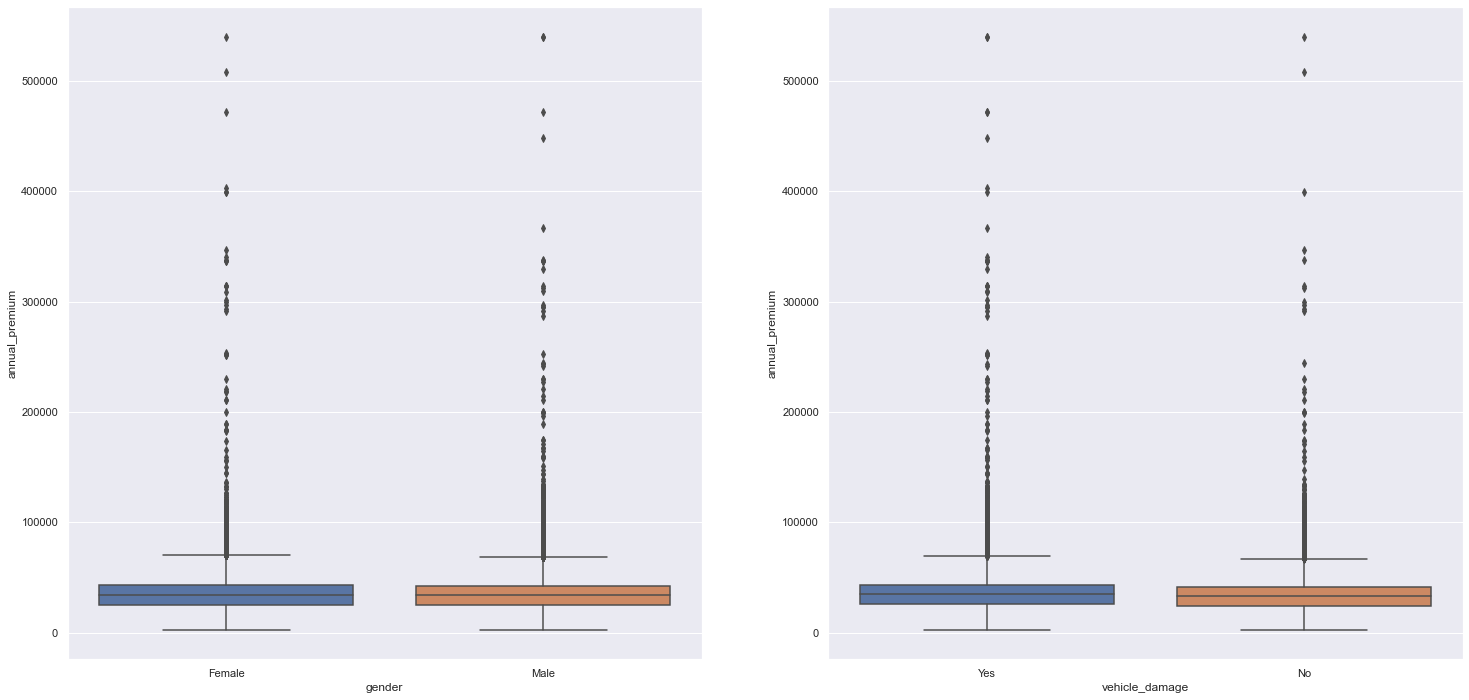

In [780]:
aux1 = df1[( df1[ 'gender' ] != '0') & (df1[ 'annual_premium' ] >0 )]

plt.subplot (1, 2, 1)
sns.boxplot (x = 'gender', y='annual_premium', data = aux1)

plt.subplot (1, 2, 2)
sns.boxplot (x = 'vehicle_damage', y='annual_premium', data = aux1)

# 2.0 Feature Engeneering - Mind Map

In [781]:
df2 = df1.copy()

# Vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' 
                                              if x == '> 2 Years' else 'between_1_2_years' 
                                              if x == '1-2 Year' else 'below_1_year')

# Vehicle demage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'yes' else 0)

## 2.1 Mind Map

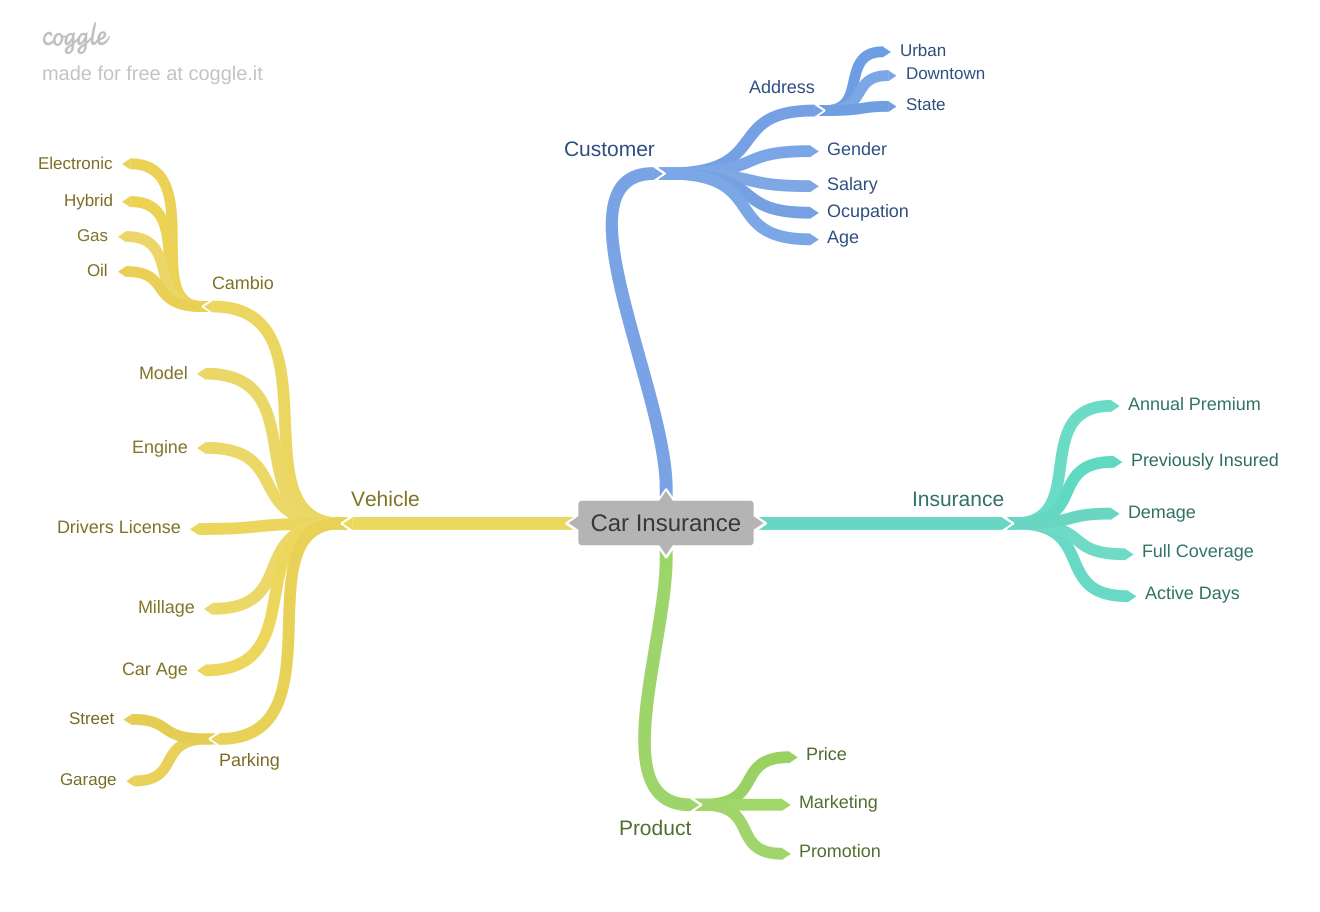

In [782]:
Image ('/Users/adriele/Documents/repos/pa004/image/mindmap.png')

## 2.2 Hypothesy List

Customer 

- 50% of female customers would be interested on the car insurance.
- Customers over 50 years old would be interested on the car insurance.
- Customers with salary up to 40k annually would be interested on the car insurance.
- 80% of Field customers wouldn't be interested on the car insurance.
- Customer outside of State wouldn't be interested on the car insurance.


Vehicle

- Customers who has cars less than one year are insterested on the car insurance.
- Customers who park doesn't have privately park are intereste on the car insurance.
- 30% of customers who has driver license would be insterested on the car insurance.
- Vehicle with new models would be insterested on the car insurance.
- 90% of car work by gas.

Insurance

- Customer with more than one damage car would be insterested on the car insurance.
- Customers that paid for annually premmiun less than 40.000 would be insterested on the car insurance.
- Customers up to 120 days of association on Health Insurance would be insterested on the car insurance.
- 80% of customers who had a previously insurance wouldn't be interested on the car insurance.



### 2.2.1  Final Hyphotesis List

- H1. 50% of female customers would be interested on the car insurance.
- H2. Customers over 50 years old would be interested on the car insurance.
- H3. 80% of Field customers wouldn't be interested on the car insurance.
- H4. Feature study - Policy Sales 
- H5. 30% of customers who has driver license would be insterested on the car insurance.
- H6. Customers who has cars less than one year are insterested on the car insurance.
- H7. H7. Feature Study - Vehicle Demage
- H8. 80% of customers who had a previously insurance wouldn't be interested on the car insurance.
- H9. Customers that paid for annually premmiun less than 40.000 would be insterested on the car insurance.
- H10. Customers up to 120 days of association on Health Insurance would be insterested on the car insurance.


# 3.0 Filtering Variables

In [783]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [784]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response variable

/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='response', ylabel='Density'>

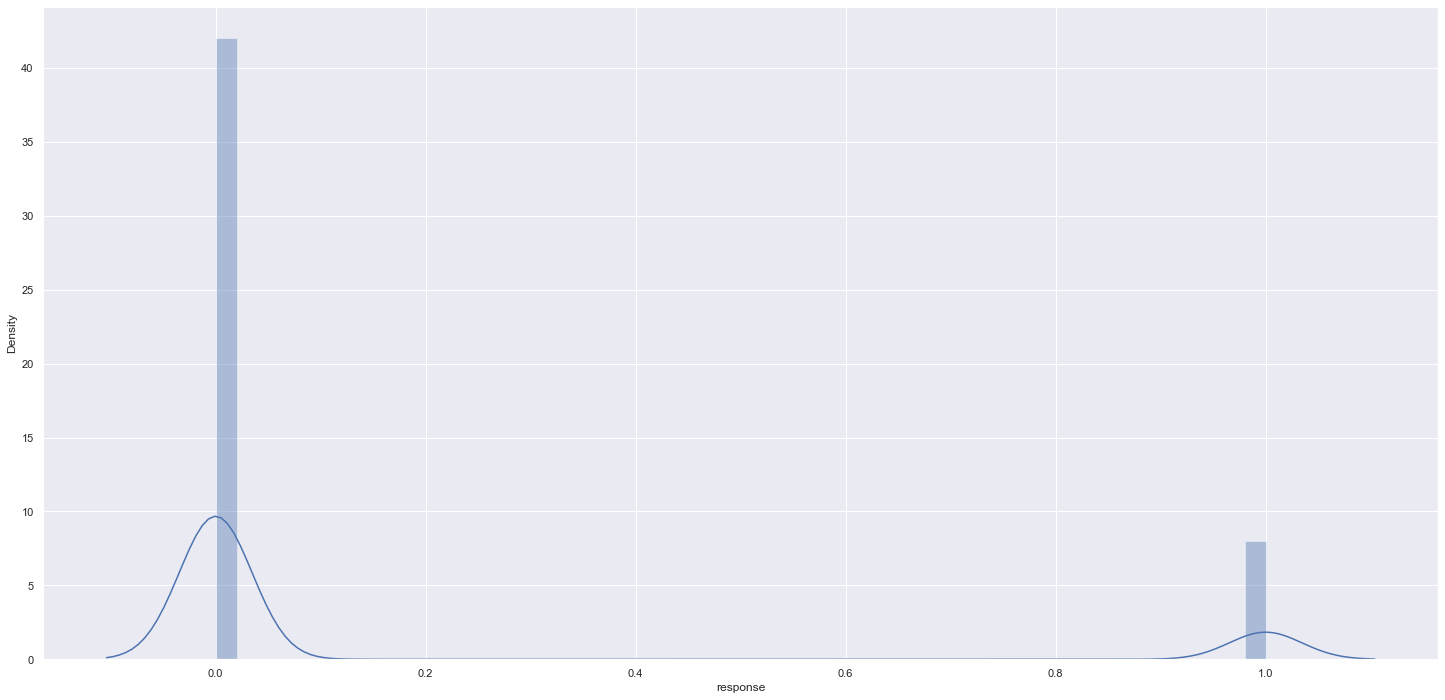

In [785]:
sns.distplot (df4['response'])

### 4.1.2 Numerical Variable

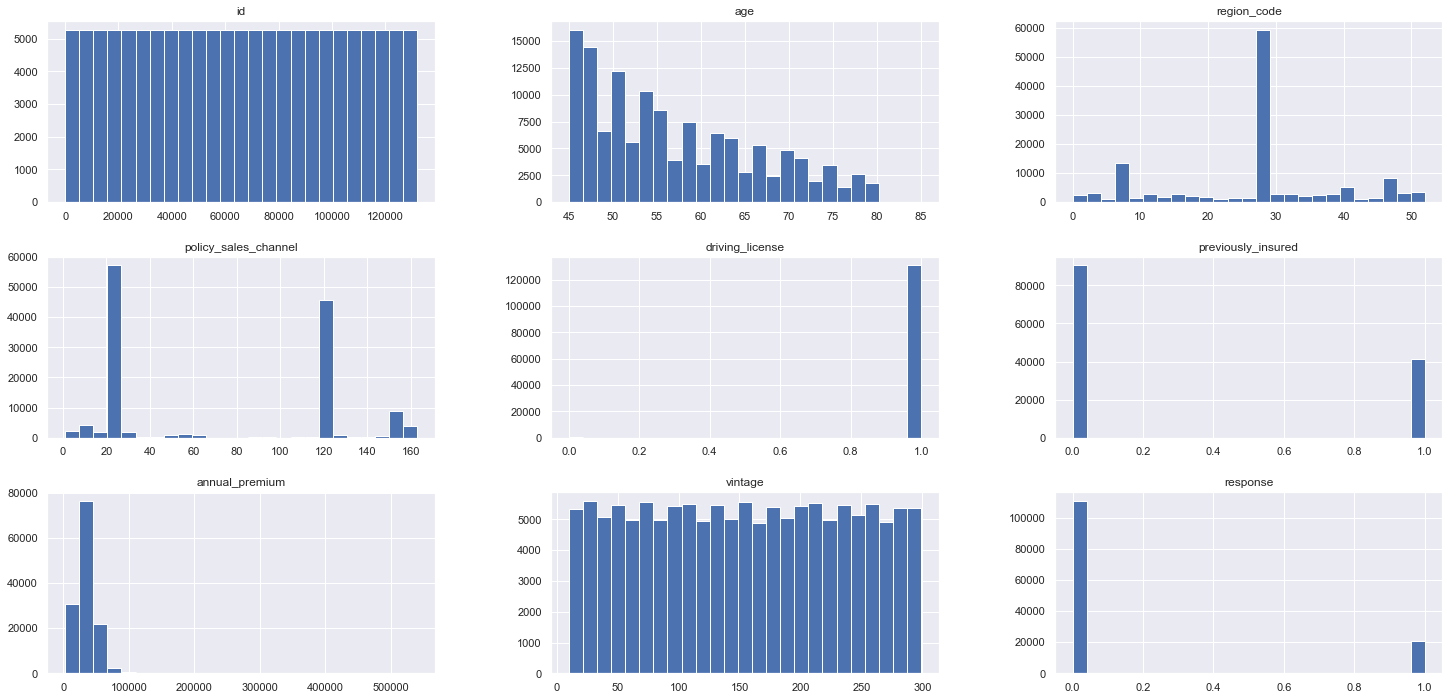

In [786]:
num_attributes.hist(bins =25);

### 4.1.3 Categorical Variable

In [787]:
cat_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

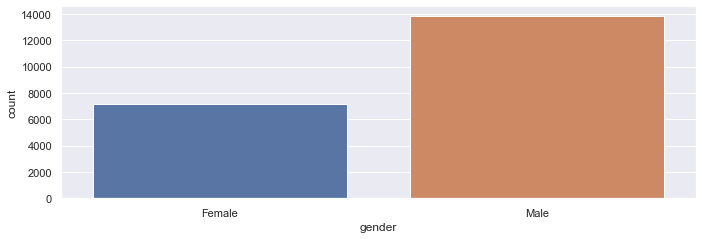

In [788]:
# Gender 
plt.subplot(3, 2, 1)
a = df4.loc[df4['response'] == 1, 'gender']
sns.countplot(a)

# plt.subplot(3, 2, 2)
# sns.kdeplot( a, label='a', shade=True)

# plt.subplot(3, 2, 3)
# sns.kdeplot(df4[df4['vehicle_damage'] == 'yes']['response'], label='a', shade=True)



## 4.2 Bivariate Analysis - Hipothesys Validatin

### <font color='orange'> 4.2.1- H1. 50% of female customers would be interested on the car insurance.
    
   <font color='green'> False - Just 5.44% are interested

/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

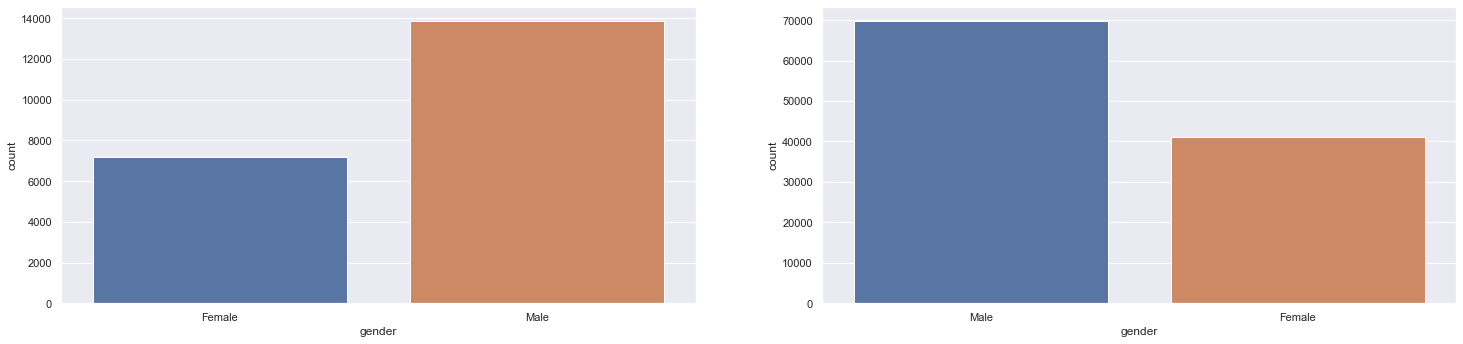

In [789]:
plt.subplot(2, 2, 1)
h0 = df4.loc[df4['response'] == 1, 'gender']
sns.countplot(h0)


plt.subplot(2, 2, 2)
h1 = df4.loc[df4['response'] == 0, 'gender']
sns.countplot(h1)




In [790]:
h6 = df4[['gender', 'response']].value_counts( normalize=True ).reset_index()
h6

,gender,response,0
0,Male,0,0.529080
1,Female,0,0.311403
2,Male,1,0.105087
3,Female,1,0.054431


- 31% Female customers are not interested.
- 5.44% Female customers interested.


- 52% Male customers are not interested.
- 10% Male customers are interested.

### <font color='orange'>  4.2.2- H2. Customers over 50 years old would be interested on the car insurance.

    
<font color='red'> False

<AxesSubplot:xlabel='age', ylabel='Count'>

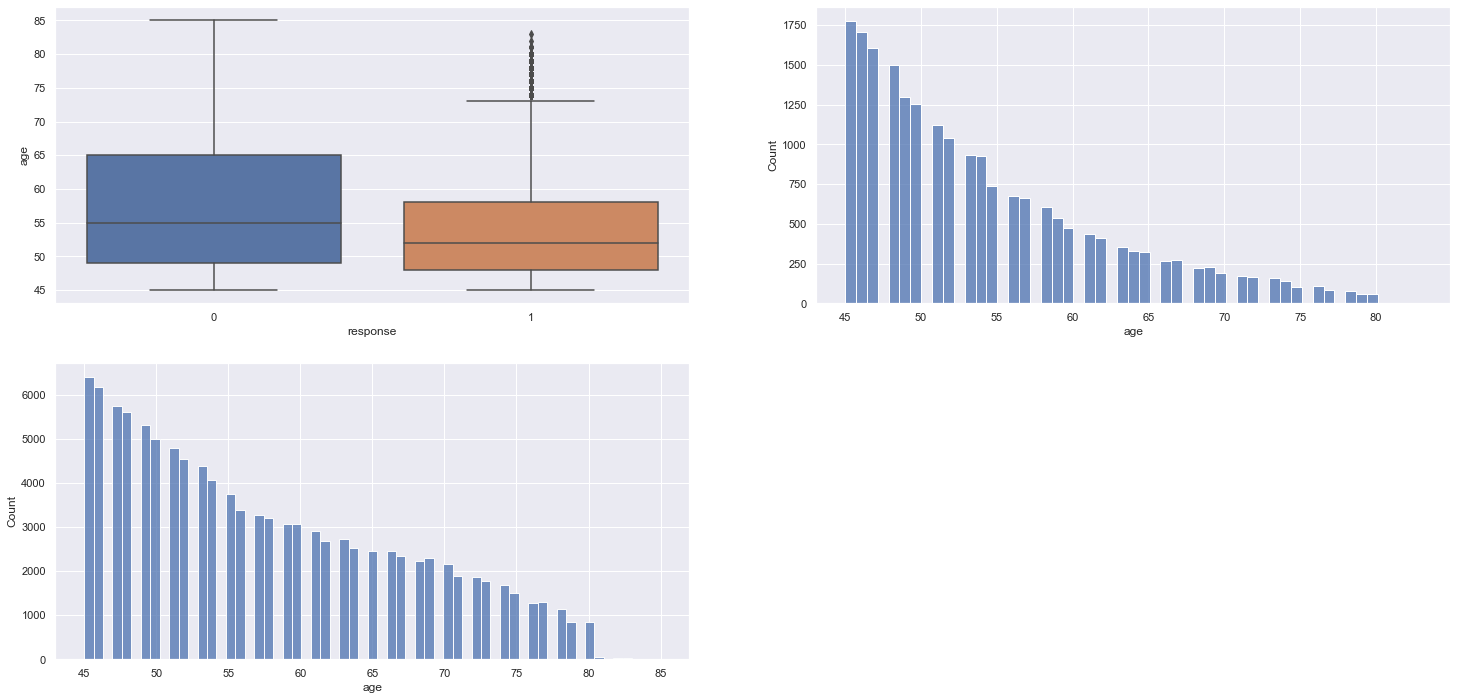

In [791]:
plt.subplot(2, 2, 1)
sns.boxplot( x='response', y='age', data=df4)

plt.subplot(2, 2, 2)
h2 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( h2 )

plt.subplot(2, 2, 3)
h2_aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot( h2_aux )

- Customer over 50 years old are not interested.

### <font color='orange'>  4.2.3 - H3. 80% of Field customers wouldn't be interested on the car insurance.
<font color='blue'>    - The data are not clear to get insights.

<AxesSubplot:xlabel='region_code', ylabel='id'>

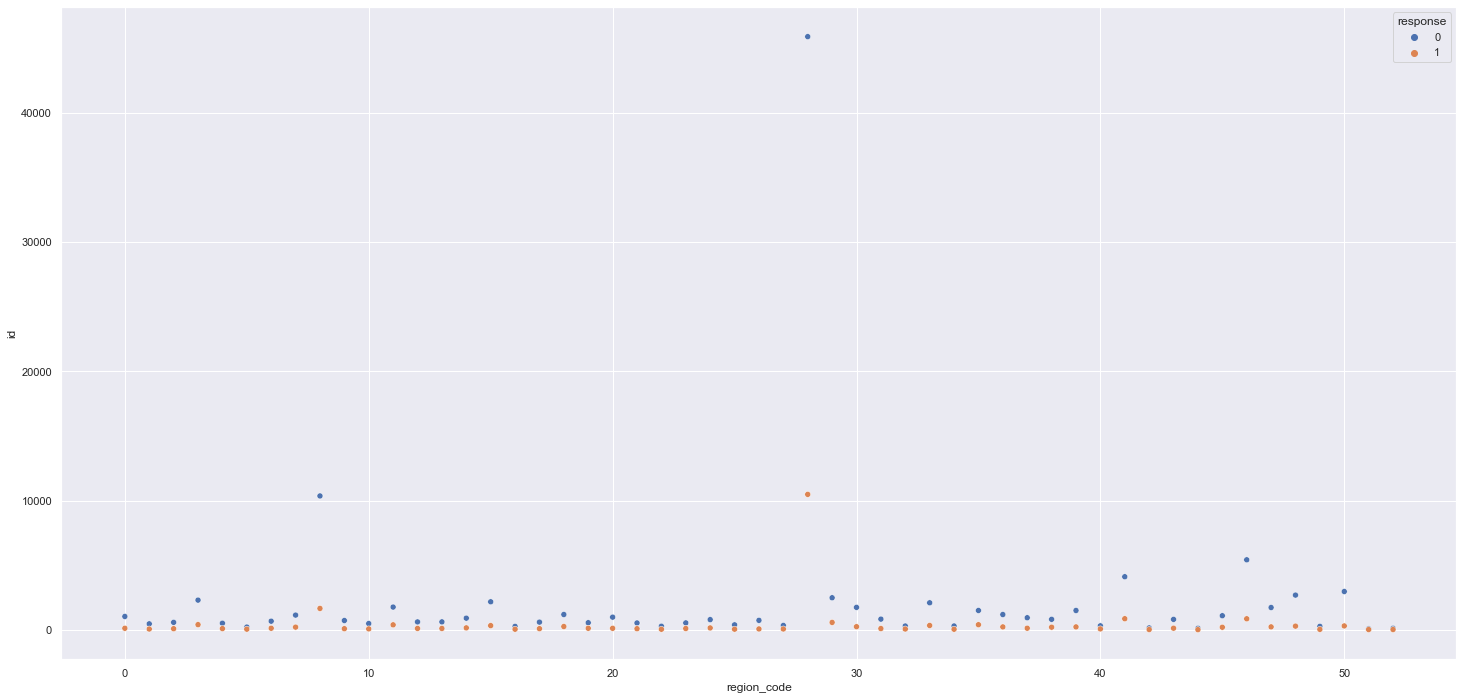

In [792]:
h3 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index() 
sns.scatterplot(x='region_code', y='id', hue='response', data=h3)

In [793]:
h3_aux = df4[['region_code', 'response']].value_counts().reset_index()
h3_aux.head()

,region_code,response,0
0,28,0,45911
1,28,1,10479
2,8,0,10358
3,46,0,5415
4,41,0,4105


- There is only one code of interested customers.

### <font color='orange'>  4.2.4- H4. Policy Sales
<font color='blue'>   The data are not clear to get insights.   

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

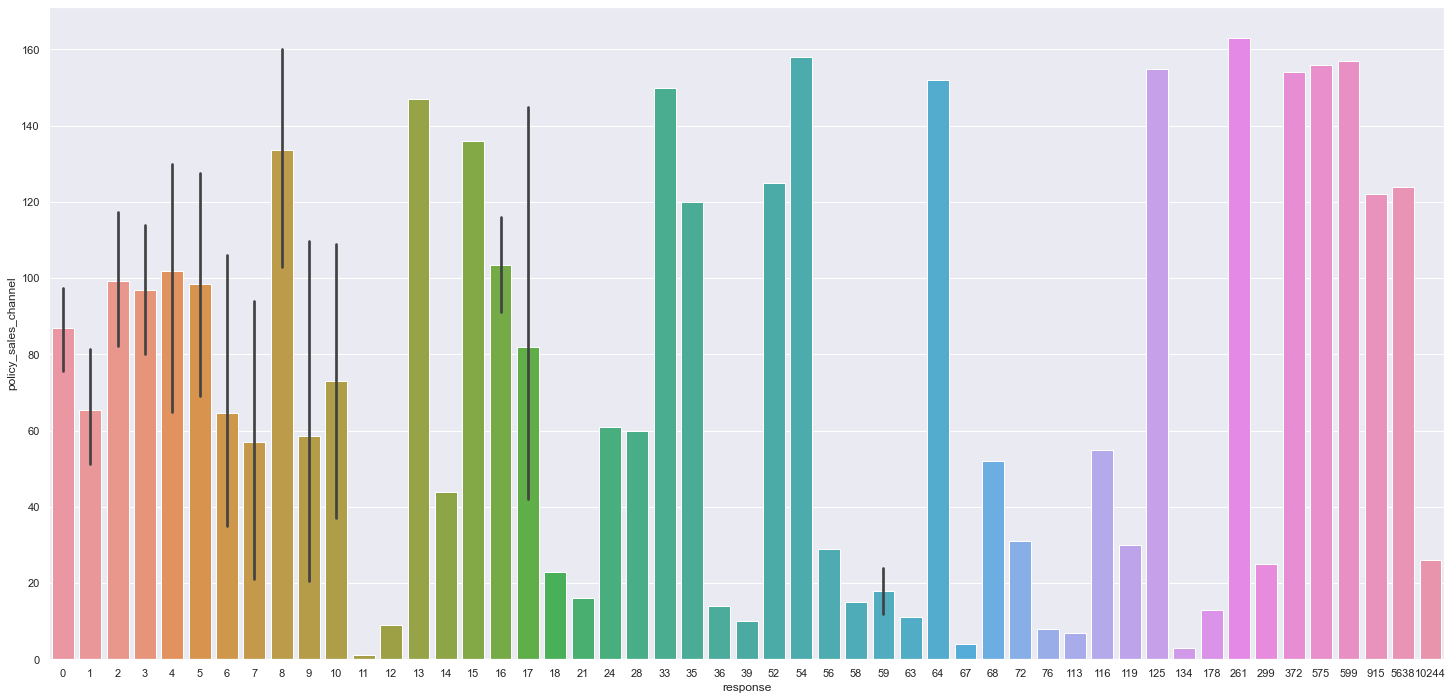

In [794]:
h4 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data= h4)

### <font color='orange'>  4.2.5 - H5. 30% of customers who has driver license would be insterested on the car insurance.
<font color='red'> False    

<AxesSubplot:xlabel='response', ylabel='driving_license'>

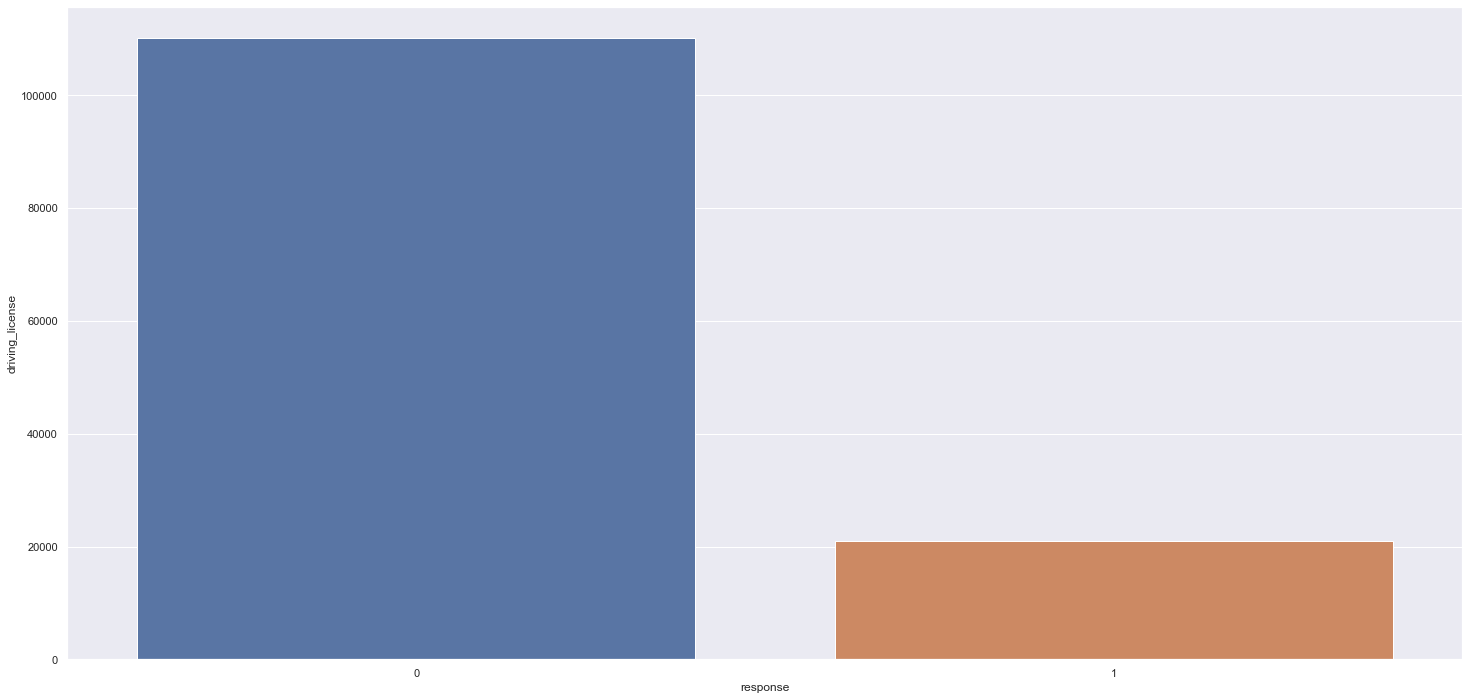

In [795]:
h5 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot( x='response', y='driving_license', data=h5 )

In [796]:
h5.head()

,response,driving_license
0,0,110160
1,1,21009


In [797]:
h5['driving_license_perc'] = h5['driving_license'] / h5['driving_license'].sum()
h5.head()

,response,driving_license,driving_license_perc
0,0,110160,0.839833
1,1,21009,0.160167


- Only 16% of custumer who has drivers license are interested.
- Most of customers doesn't have drivers license.

### <font color='orange'>  4.2.6 - H6. Customers who has cars less than one year are insterested on the car insurance.
<font color='red'>    False

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

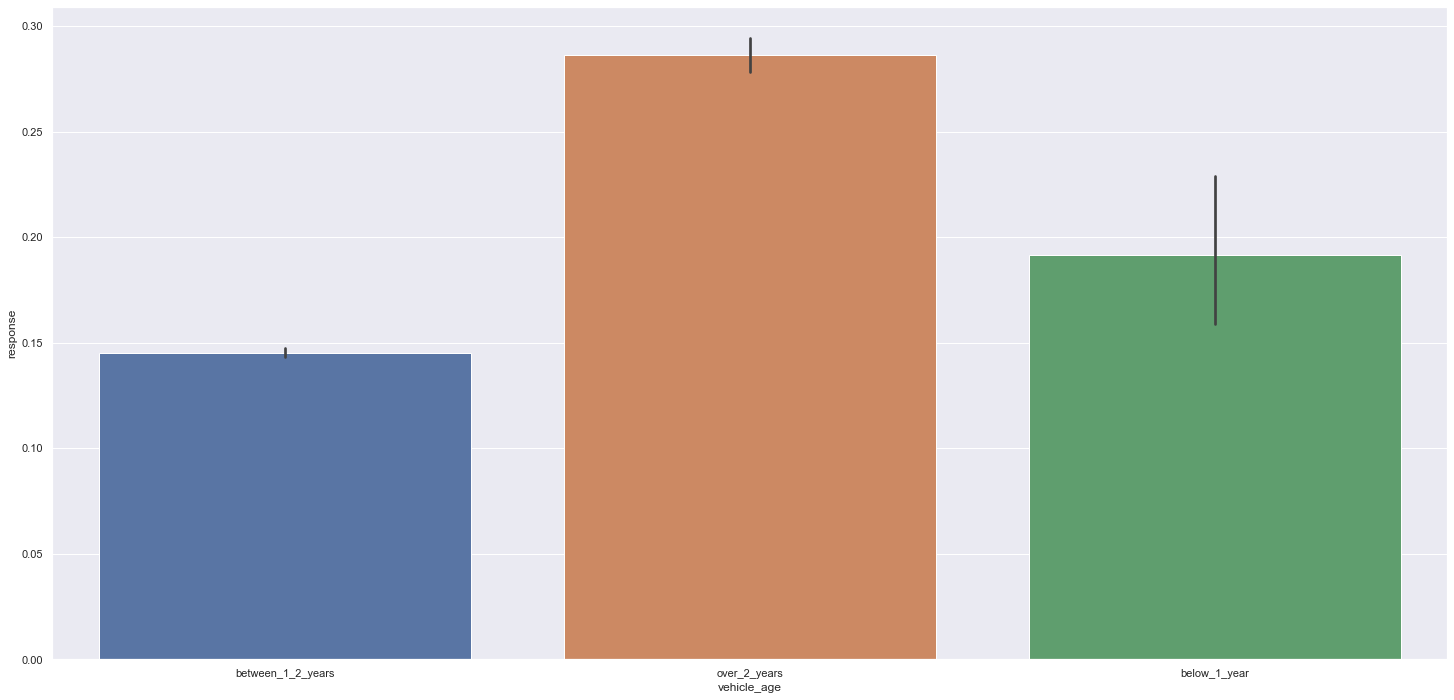

In [798]:
sns.barplot(x='vehicle_age', y='response', data=df4)

/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

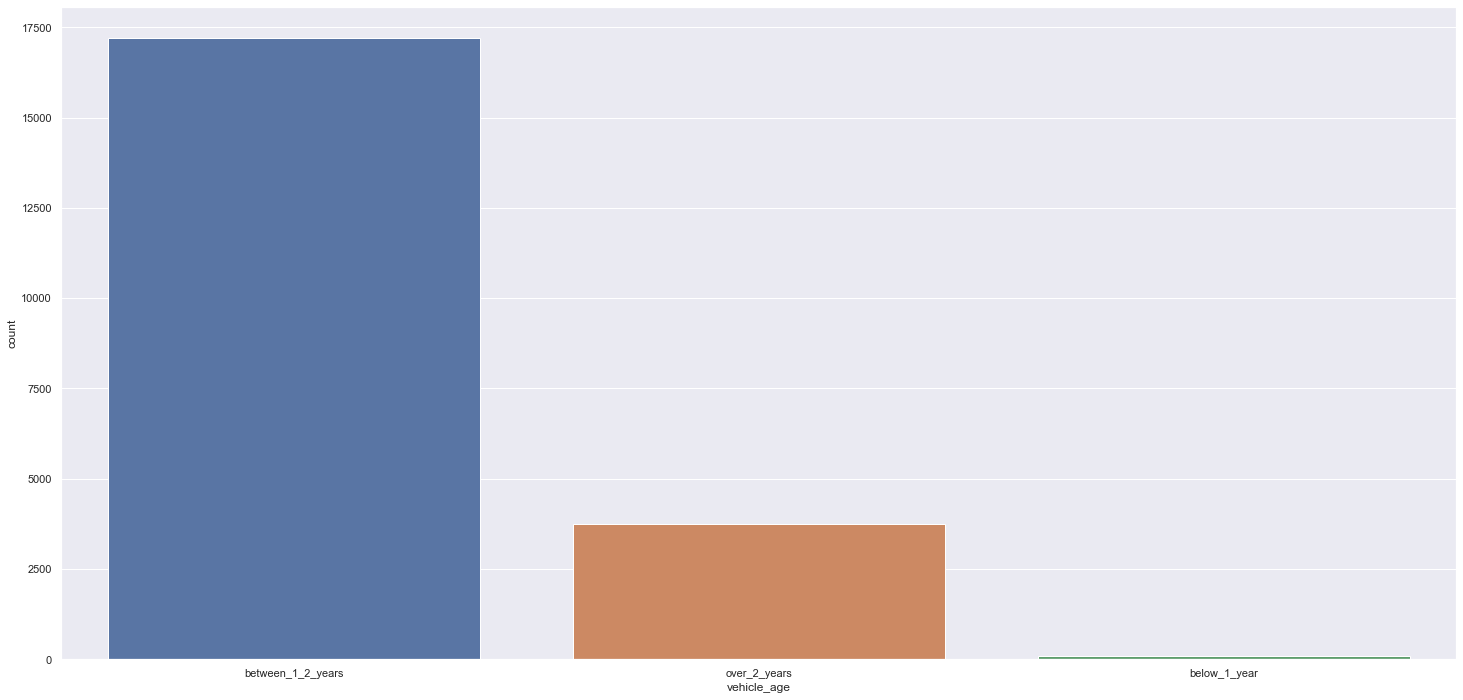

In [799]:

h = df4.loc[df4['response'] == 1, 'vehicle_age']
sns.countplot(h)

In [800]:
h6 = df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()
h6

,vehicle_age,response,0
0,between_1_2_years,0,0.766643
1,between_1_2_years,1,0.130385
2,over_2_years,0,0.070869
3,over_2_years,1,0.028428
4,below_1_year,0,0.002971
5,below_1_year,1,0.000705


- Bellow 1 year = 0.07% of customer interested.
- Between 1 and 2 yars = 13% of customer interested.
- Over years = 2.80% of customer interested.

### <font color='orange'>  4.2.7 - H7. Feature Study - Vehicle Demage
<font color='blue'>   There are no data to get insights.   

<AxesSubplot:xlabel='response', ylabel='vehicle_damage'>

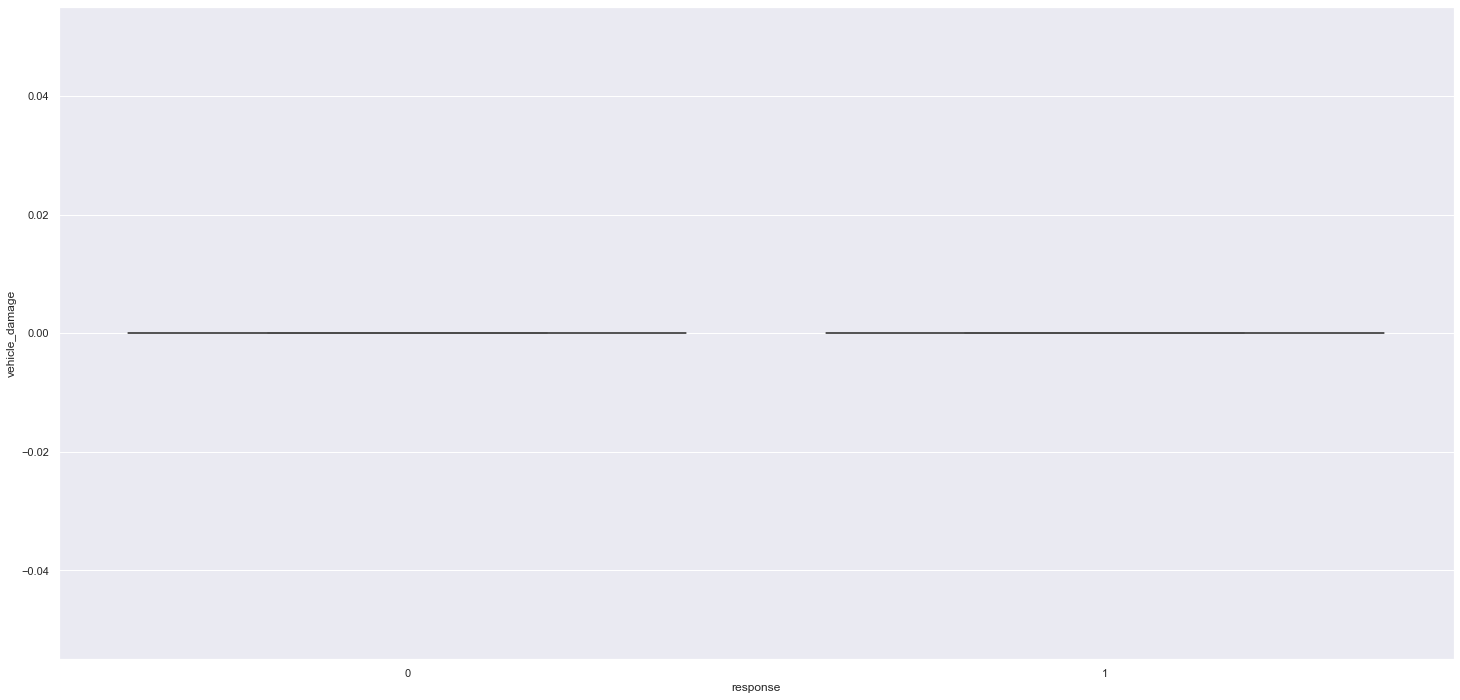

In [801]:
sns.boxplot( x='response', y='vehicle_damage', data=df4)

In [802]:
h = df4[['vehicle_damage', 'response']].value_counts( normalize=True ).reset_index()


In [803]:
#h5 = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
#sns.barplot( x='response', y='vehicle_damage', data=h5 )

h['vehicle_damage_perc'] = h['vehicle_damage'] / h['vehicle_damage'].sum()
h.head()

,vehicle_damage,response,0,vehicle_damage_perc
0,0,0,0.840483,NaN
1,0,1,0.159517,NaN


<AxesSubplot:xlabel='vehicle_damage', ylabel='age'>

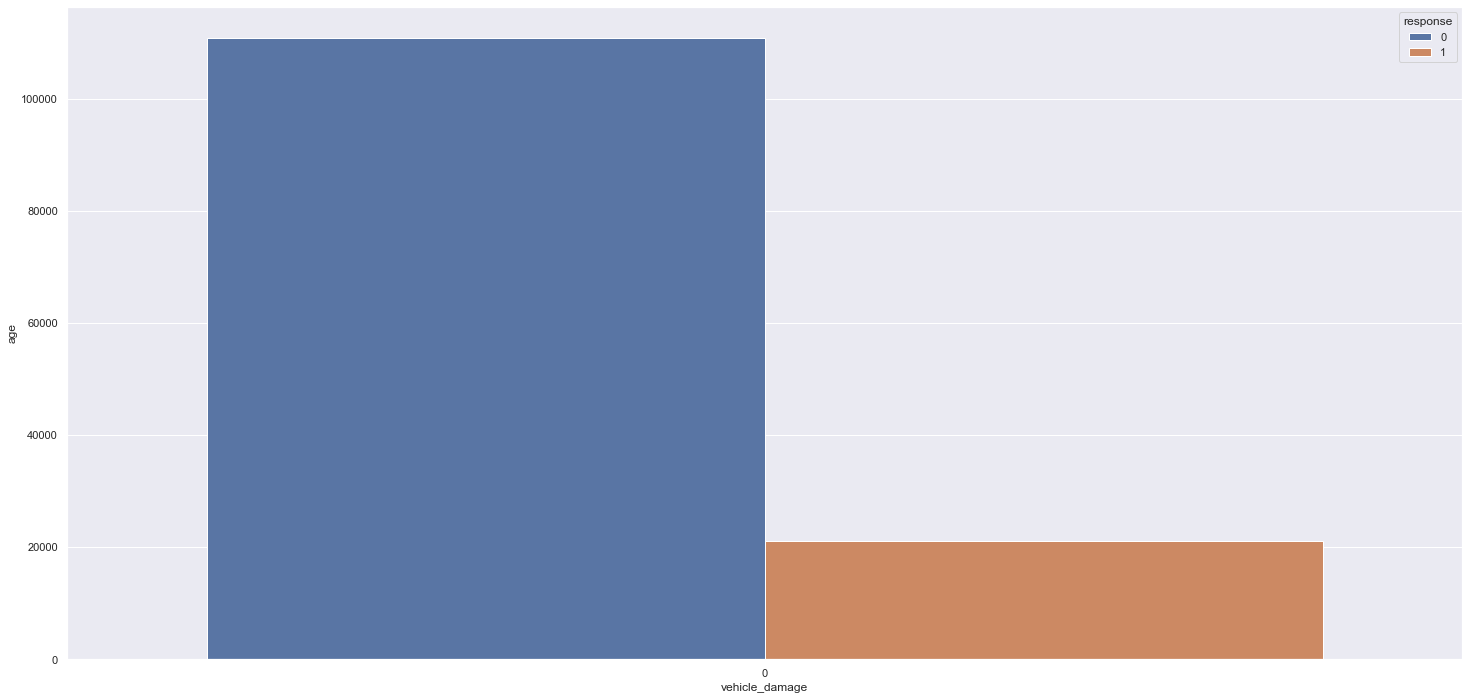

In [804]:
h = df4[['age', 'vehicle_damage', 'response']].groupby( ['vehicle_damage', 'response'] ).count().reset_index() 
sns.barplot(x='vehicle_damage', y='age', hue='response', data=h)

### <font color='orange'>  4.2.8 - H8. 80% of customers who had a previously insurance wouldn't be interested on the car insurance.
<font color='blue'>    True - More than 80% are not interested.

In [805]:
h8 = pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1)
h8.head()

response,0,1
previously_insured,,
0,0.768037,0.231963
1,0.999178,0.000822


- Only 0.23% of Customers who had a previously Insurance are interested.
- Only 0.00082% of Customers didn't have a previously Insurance are interested.

<AxesSubplot:xlabel='response', ylabel='previously_insured'>

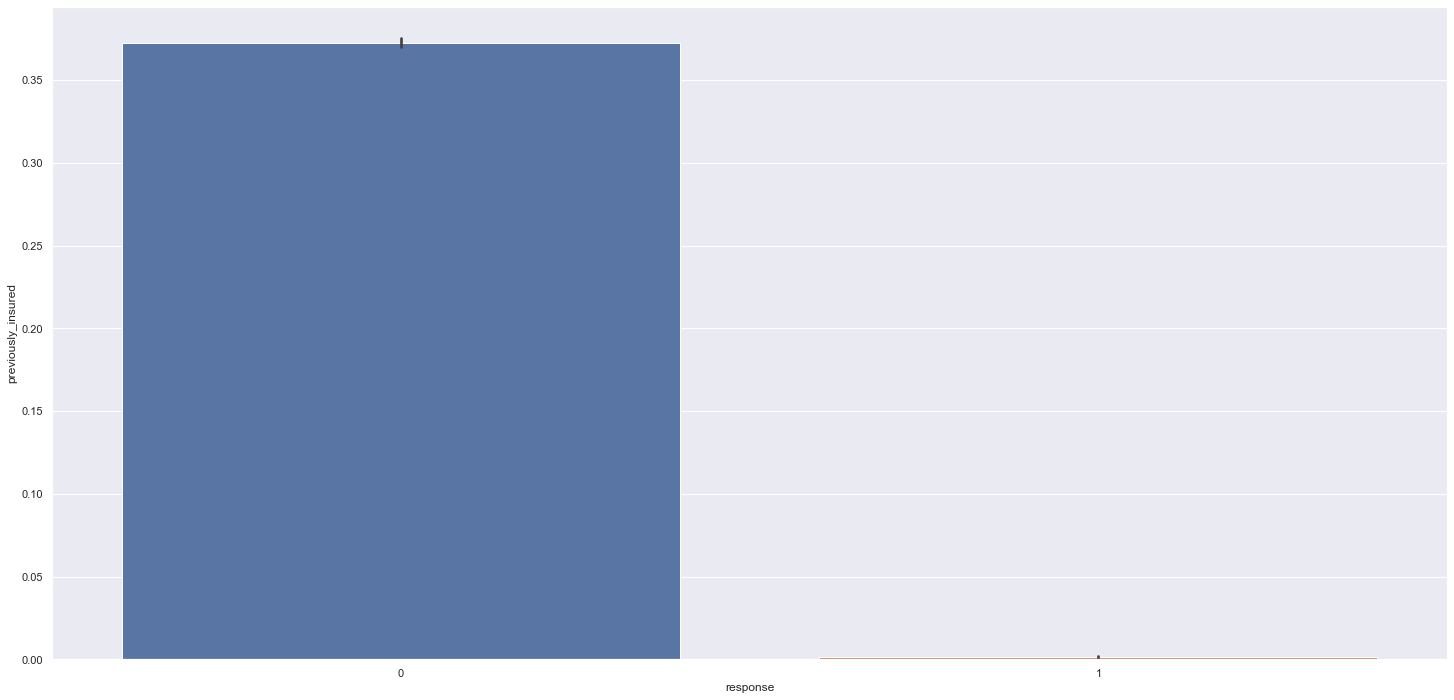

In [806]:
sns.barplot(x='response', y='previously_insured', data=df4)

### <font color='orange'>  4.2.9 - H9. Customers that paid for annually premmiun less than 40.000 would be insterested on the car insurance.
    
<font color='green'> True

In [807]:
df3['annual_premium'].max()


540165

In [808]:
df3['annual_premium'].min()

2630

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

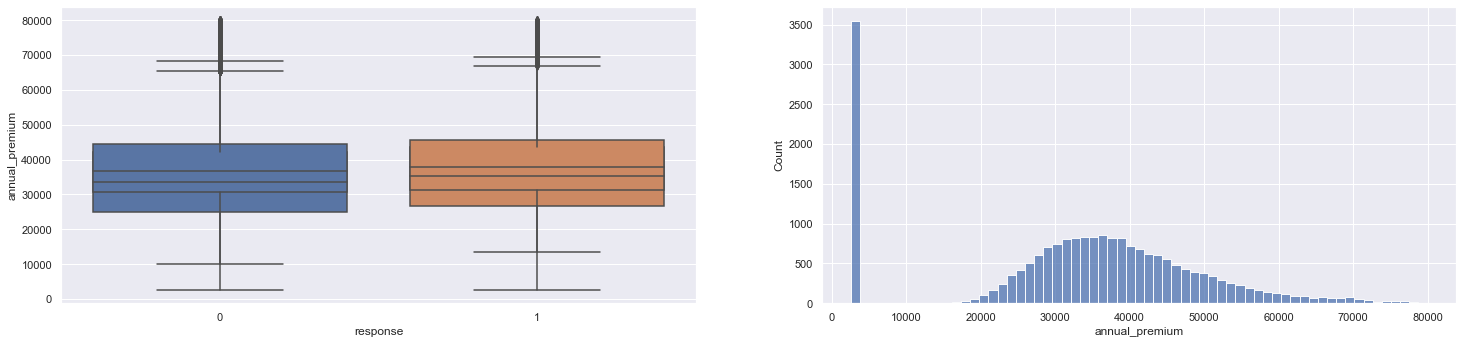

In [809]:

plt.subplot(2, 2, 1)
h9 = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=h9 )

plt.subplot(2, 2, 2)
h9_aux = h9.loc[h9['response'] == 1, 'annual_premium' ]
sns.histplot(h9_aux )

plt.subplot(2, 2, 1)
h9 = df4[(df4['annual_premium'] > 2630) & (df4['annual_premium'] < 80000)]
sns.boxplot( x='response', y='annual_premium', data=h9 )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

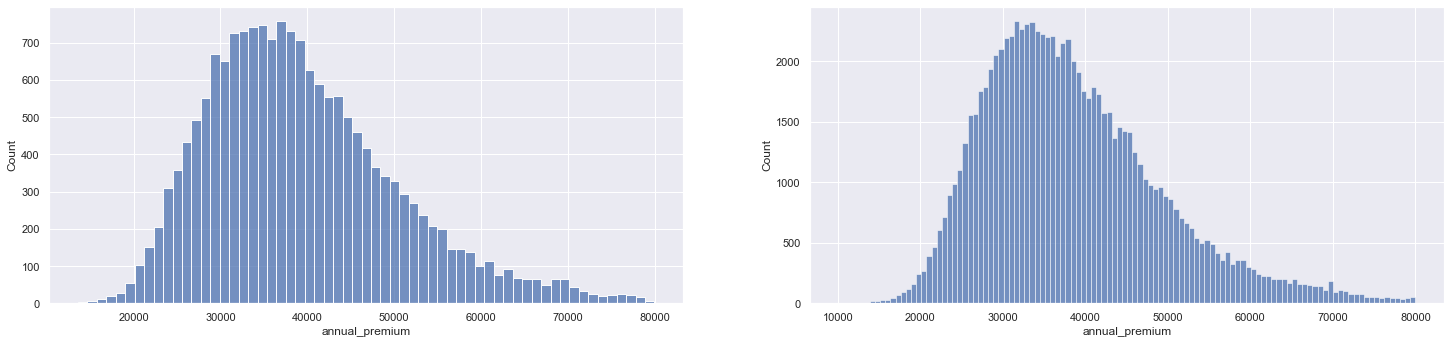

In [810]:
plt.subplot(2, 2, 1)
h9_aux1 = df4[(df4['annual_premium'] > 2630) & (df4['annual_premium'] < 80000)]
h9_aux2 = h9_aux1.loc[h9['response'] == 1, 'annual_premium' ]                                                                                          
sns.histplot( h9_aux2 )

plt.subplot(2, 2, 2)
h9_aux1 = df4[(df4['annual_premium'] > 2630) & (df4['annual_premium'] < 80000)]
h9_aux2 = h9_aux1.loc[h9['response'] == 0, 'annual_premium' ]                                                                                          
sns.histplot( h9_aux2 )

- The most interested Customere are who paid between 30,000 and 40,000.

### <font color='orange'>  4.2.10 - H10. Customers up to 120 days of association on Health Insurance would be insterested on the car insurance.
<font color='blue'> Not possible to valide the Hypothesis.  

<AxesSubplot:xlabel='vintage', ylabel='Count'>

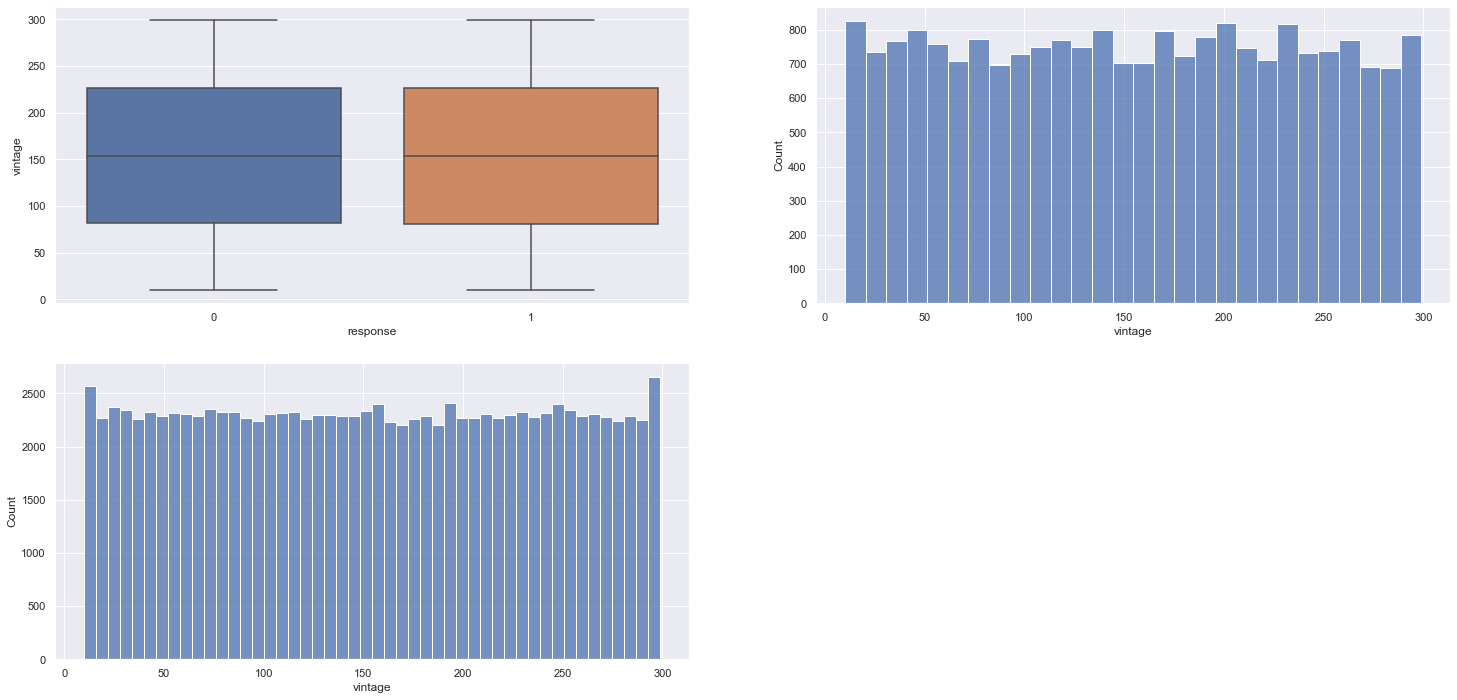

In [811]:
plt.subplot(2, 2, 1)
sns.boxplot( x='response', y='vintage', data=df4)

plt.subplot(2, 2, 2)
h10 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( h10 )

plt.subplot(2, 2, 3)
h10 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( h10 )

- The number of customers who would buy the insurance is shown to be the same as those who wouldn't buy it either.

## 4.3 Hypothesis Resume


In [812]:
tab = [[ 'Hipothesys', 'Conclusion'],
       [ 'H1', 'False'],
       [ 'H2', 'False'],
       [ 'H3', '-', '-'],
       [ 'H4', '-', '-'],
       [ 'H5', 'False'],
       [ 'H6', 'False'], 
       [ 'H7', '-', '-'],
       [ 'H8', 'True'],
       [ 'H9', 'True'],
       [ 'H10', '-', '-']
      ]

print (tabulate (tab, headers = 'firstrow'))

Hipothesys    Conclusion
------------  ------------
H1            False
H2            False
H3            -
H4            -
H5            False
H6            False
H7            -
H8            True
H9            True
H10           -


## 4.4 Multivariate Analysis

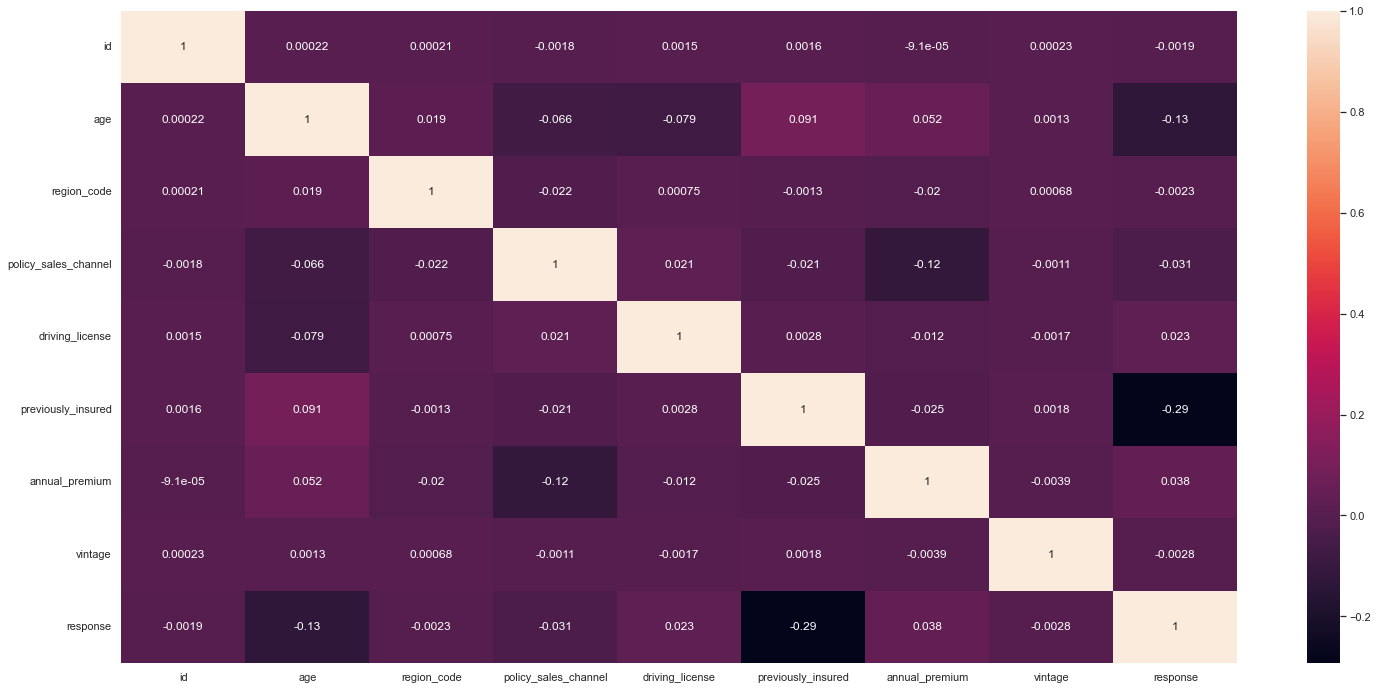

In [813]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot = True);

# 5.0 Data Preparation

In [814]:
df5 = df4.copy()

In [815]:
x = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size=0.20 )
df5 = pd.concat( [x_train, y_train], axis=1 )

In [816]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage
14706,14706,Female,70,31,124,1,between_1_2_years,0,0,2630,89
16657,16657,Female,45,28,122,1,between_1_2_years,0,0,69856,152
81641,81641,Male,65,12,26,1,between_1_2_years,0,1,2630,240
63487,63487,Male,49,28,55,1,between_1_2_years,0,0,41461,52
103511,103511,Male,45,37,152,1,between_1_2_years,0,1,33898,112


## 5.1 Standarlization

In [817]:
ss = pp.StandardScaler()

# Annual Premium
df5['annual_premium'] = ss.fit_transform( df5[[ 'annual_premium']].values)
pickle.dump (ss, open( '/Users/adriele/Documents/repos/pa004/features/annual_premium_scaler.pkl', 'wb') )


## 5.2 Rescaling

In [818]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump (mms_age, open( '/Users/adriele/Documents/repos/pa004/features/age_scaler.pkl', 'wb') )

# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values)
pickle.dump (mms_vintage, open( '/Users/adriele/Documents/repos/pa004/features/vintage_scaler.pkl', 'wb') )

## 5.3 Encolding

In [819]:
# Region Code
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '/Users/adriele/Documents/repos/pa004/features/target_encode_region_code_scaler.pkl', 'wb') )

# gender
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '/Users/adriele/Documents/repos/pa004/features/target_encode_gender_scaler.pkl', 'wb') )

# vehicle_age
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '/Users/adriele/Documents/repos/pa004/features/fe_policy_sales_channel_scaler.pkl', 'wb') )

## 5.4 Validation Preparation

In [820]:
#gender
x_validation.loc[:, 'gender'] = x_validation['gender'].map( target_encode_gender )

# region code
x_validation.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# Annual Premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[[ 'annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# Vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values)

# fill NA
x_validation = x_validation.fillna( 0 )


In [821]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
14706,14706,0.148476,0.625,0.0,0.293289,1,0,0,-1.542951,0.273356,0,1,0
16657,16657,0.148476,0.000,0.0,0.048163,1,0,0,1.953826,0.491349,0,1,0
81641,81641,0.165826,0.500,0.0,0.415099,1,0,1,-1.542951,0.795848,0,1,0
63487,63487,0.165826,0.100,0.0,0.006480,1,0,0,0.476853,0.145329,0,1,0
103511,103511,0.165826,0.000,0.0,0.025825,1,0,1,0.083462,0.352941,0,1,0


# 6.0 Feature Selection

In [822]:
df6 = df5.copy()

## 6.1 Boruta

In [823]:
# training and test dataset for boruta
x_train_n = df6.drop (['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel ()

# model definition
et = en.ExtraTreesClassifier(n_jobs=-1)
# Defining boruta
boruta = BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit (x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	11
I

In [824]:
cols_selected = boruta.support_.tolist()

# Best features
x_train_fs = df6.drop (['id', 'response'], axis=1)
cols_selected_boruta = x_train_fs.iloc [:, cols_selected].columns.to_list()

# Not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

In [825]:
cols_selected

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

## 6.2 Feature Definition

In [826]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                         feature  importance
0                        vintage    0.311803
0                 annual_premium    0.282313
0                            age    0.143748
0                    region_code    0.111686
0             previously_insured    0.079569
0           policy_sales_channel    0.053747
0                         gender    0.006046
0       vehicle_age_over_2_years    0.005132
0  vehicle_age_between_1_2_years    0.004592
0                driving_license    0.000854
0       vehicle_age_below_1_year    0.000509
0                 vehicle_damage    0.000000


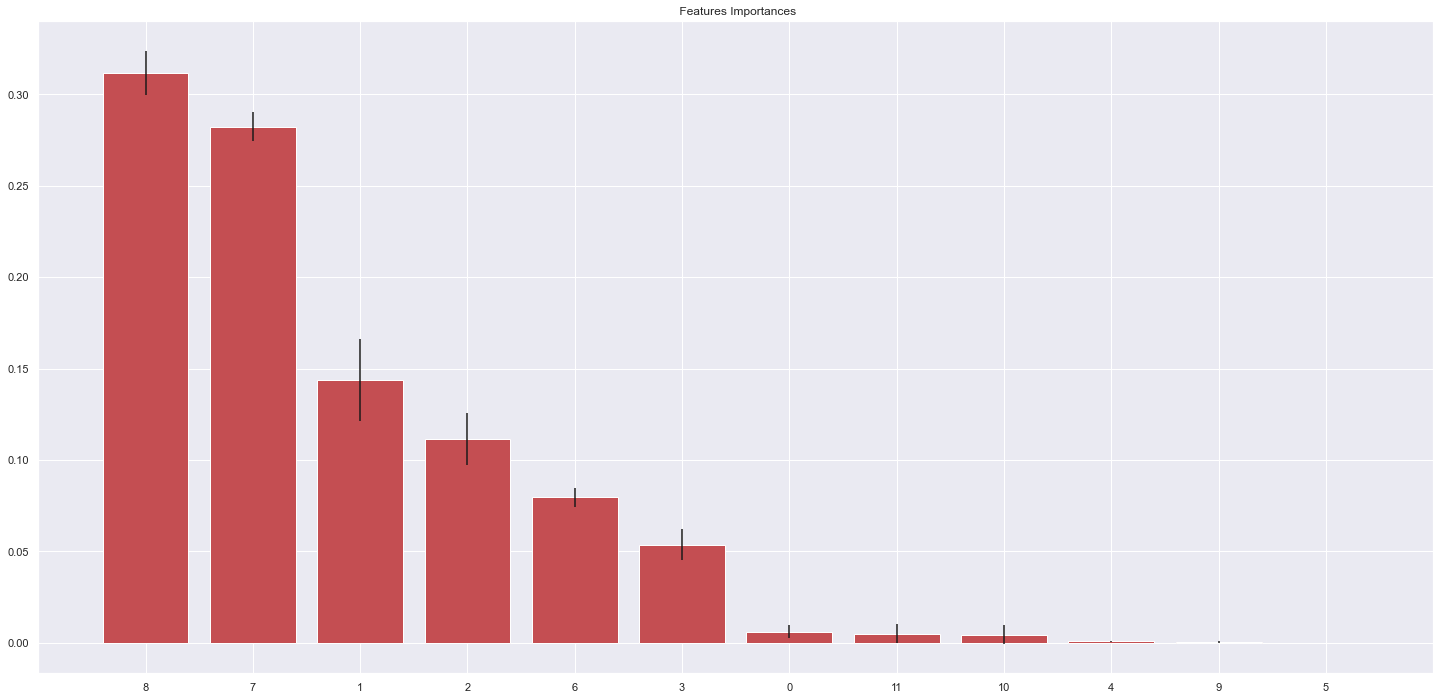

In [827]:
importances = forest.feature_importances_
std         = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices     = np.argsort(importances) [::-1]

# Print Features Rankings
print( 'Feature Ranking:')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance' : j}, index=[0])
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )   


# Plot the impurity based importances of the forest
plt.figure()
plt.title(" Features Importances")
plt.bar( range( x_train_n.shape[1] ), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks( range( x_train_n.shape[1] ), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()    

# 7.0 Machine Learning

In [828]:
#cols_selected = ['vintage','annual_premium', 'age', 'region_code', 'previously_insured', 'policy_sales_channel', 'gender'] 

cols_selected = ['vintage','annual_premium', 'age', 'region_code','vehicle_damage',
                 'previously_insured', 'policy_sales_channel', 'gender'] 

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected]
y_val = y_validation


## 7.1 KNN

In [829]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - the power of model; generalization
yhat_knn = knn_model.predict_proba( x_val)



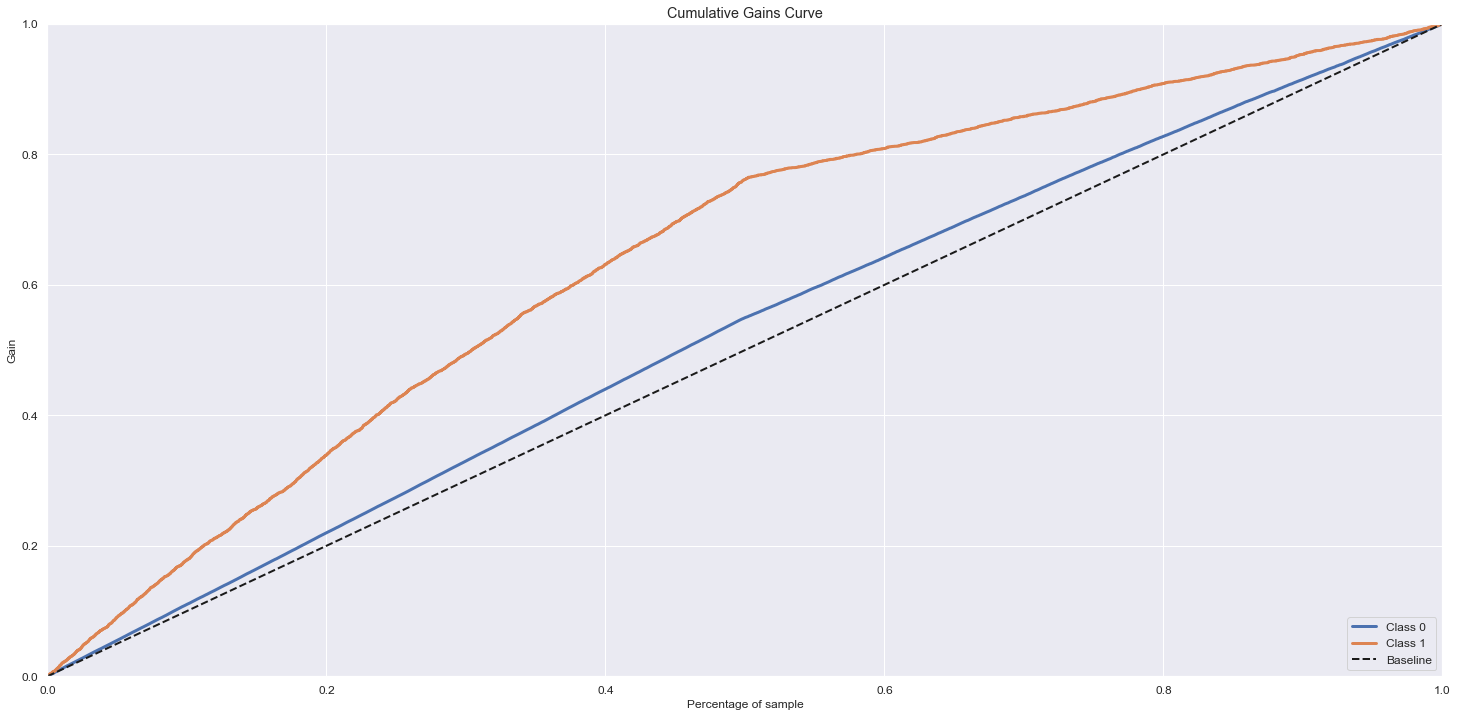

In [830]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

* Linha laranja = È a predicao do modelo 
* Linha Azul = são os dados de teste  
* Linha tracejada  = É a base de dados. 

Analises

* Significa se o dataset for classificado pela probabilidade, para contemplar 100% dos interessados,será preciso ultilizar praticamente 100% da base de dados.



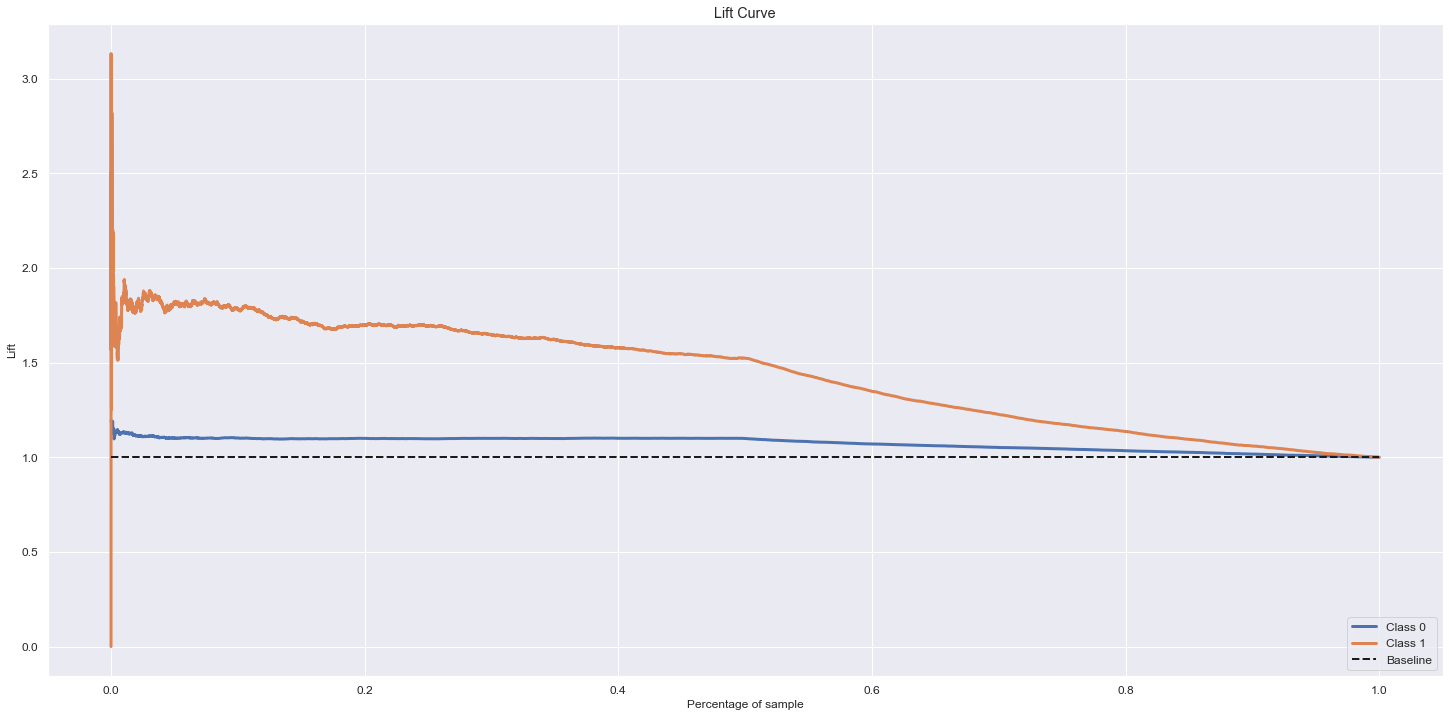

In [831]:
# Acumulative Gain
skplt.metrics.plot_lift_curve( y_val, yhat_knn );


* Significa que para a classificação de clientes interessados, o modelo é 1.60 melhor do que fazer a seleção aleatória do dataset para atingir 50% do interessedos.

## 7.2 Logistic Regression 

In [832]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train )

# model prediction - the power of model; generalization
yhat_lr = lr_model.predict_proba( x_val)



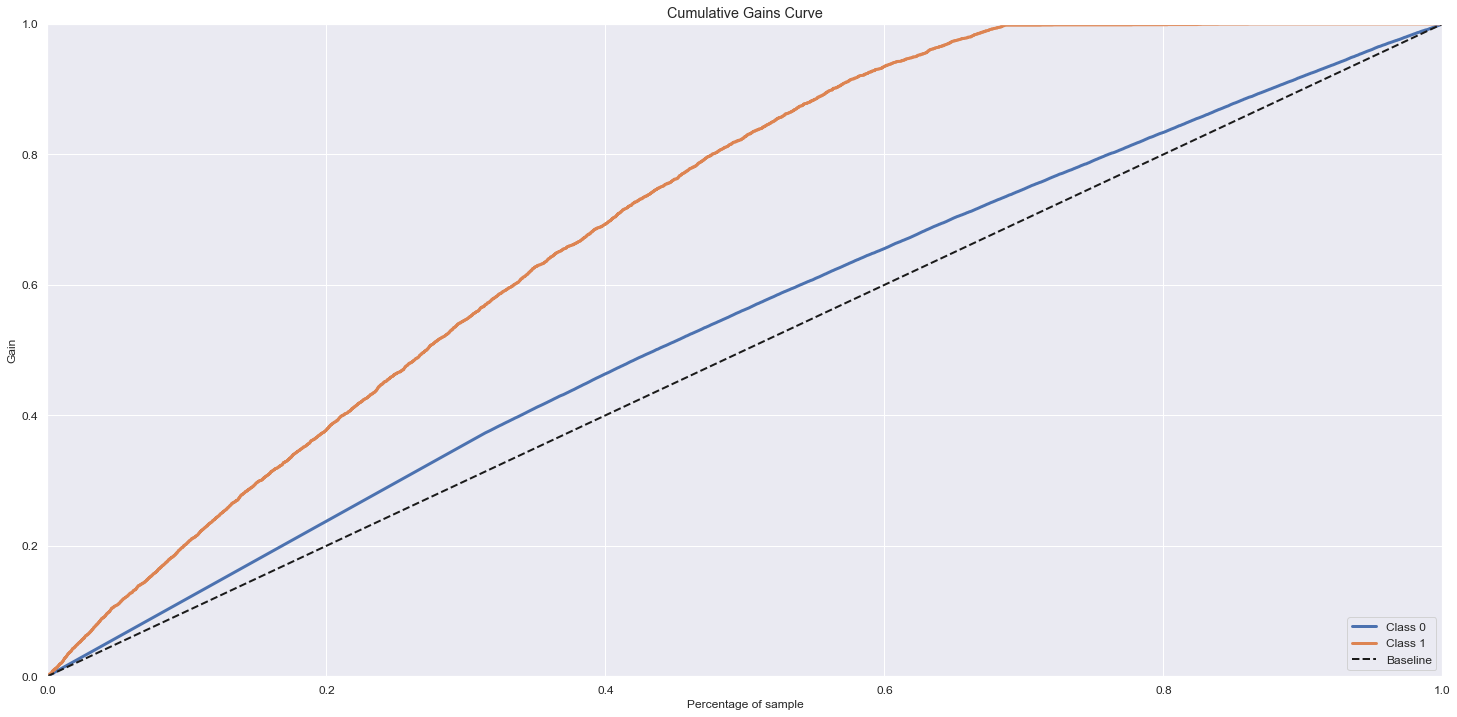

In [833]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

* Linha laranja = È a predicao do modelo 
* Linha Azul = são os dados de teste  
* Linha tracejada  = É a base de dados. 

Analises

* Significa se o dataset for classificado pela probabilidade, para contemplar 100% dos interessados,será preciso apenas aproximadamente 67% da base de dados.

* A empresa diminuiria custos ao descartar 33% não interessados.

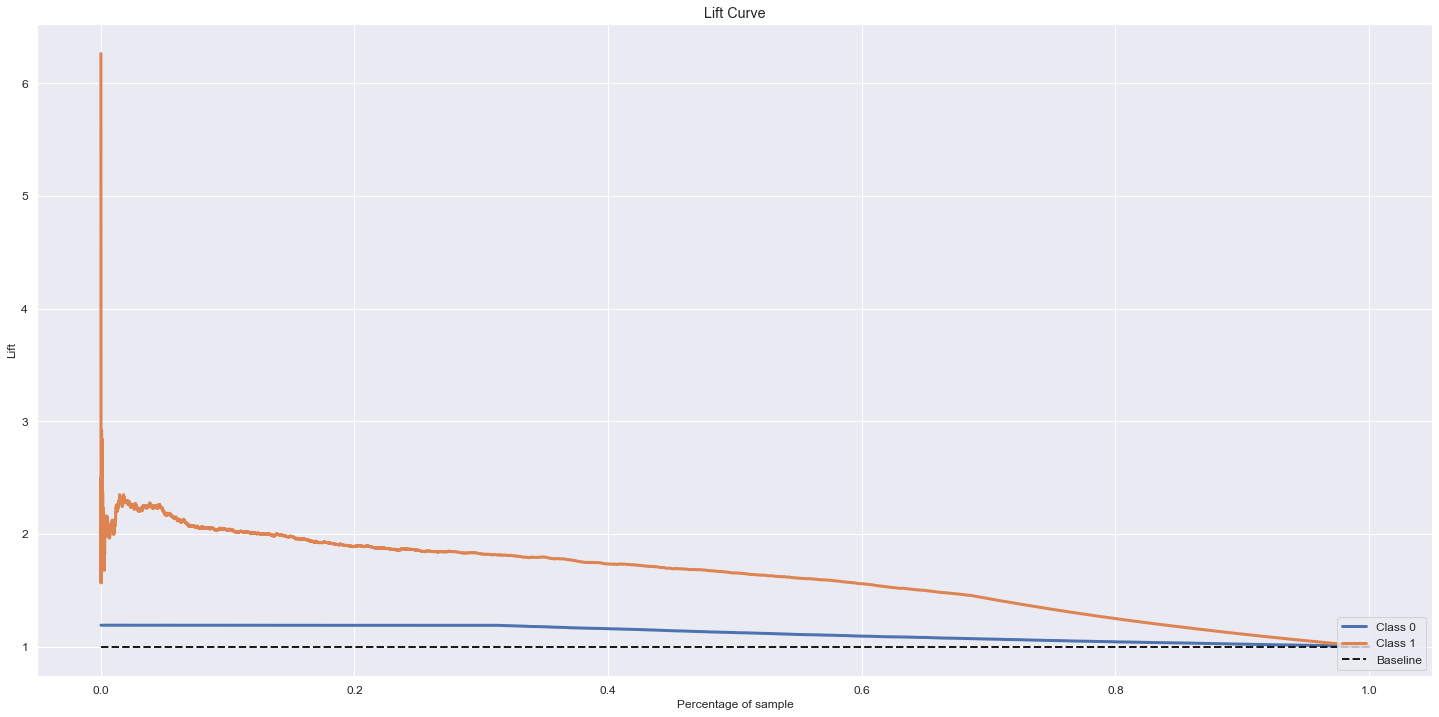

In [834]:
# Acumulative Gain
skplt.metrics.plot_lift_curve( y_val, yhat_lr );



* Significa que para a classificação de clientes interessados, o modelo é 2.20 melhor do que fazer a seleção aleatória do dataset mas logo começa a cair gradualmente o número de clientes interessados.


## 7.3 Extra Trees

In [835]:
# Model Definition
et= en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et.fit(x_train, y_train)

# model predict
yhat_et = et.predict_proba( x_val )






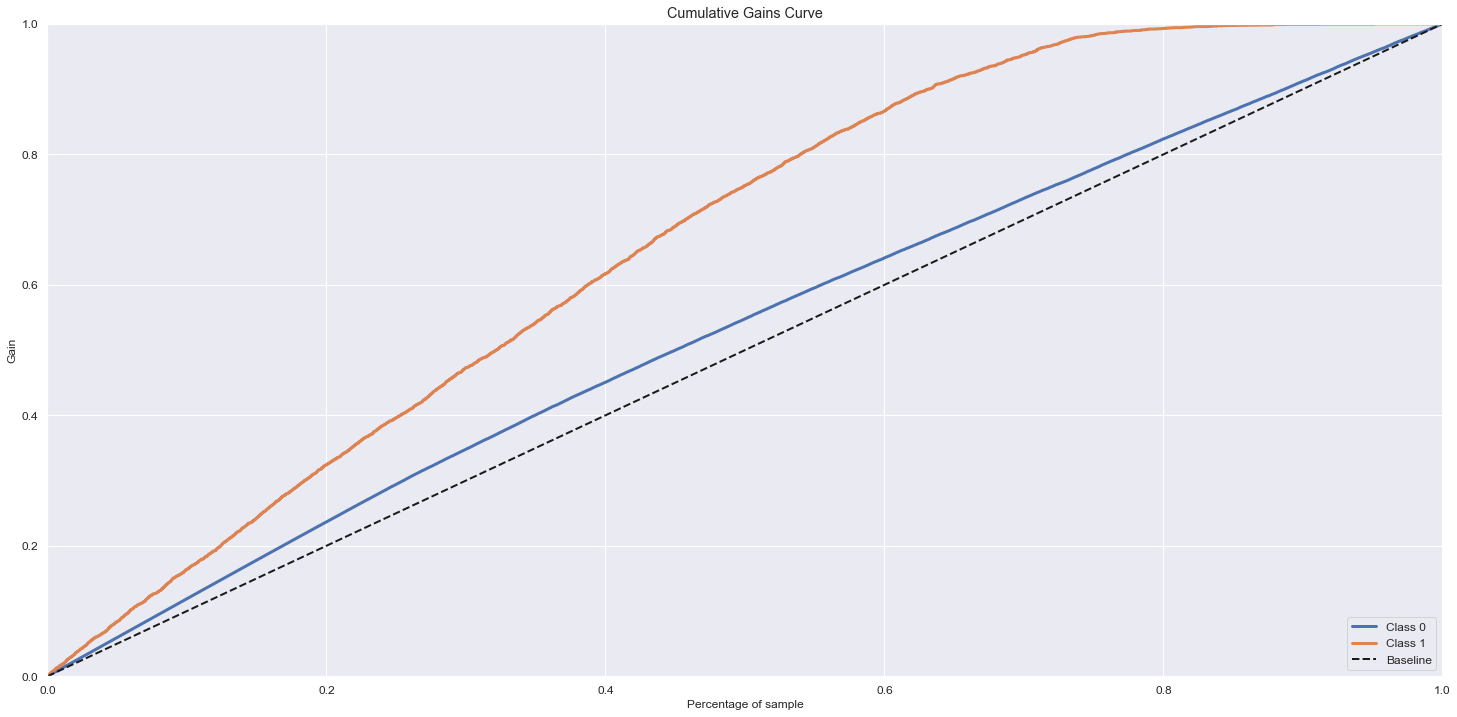

In [836]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );


* Linha laranja = È a predicao do modelo 
* Linha Azul = são os dados de teste  
* Linha tracejada  = É a base de dados. 

Analises

* Significa se o dataset for classificado pela probabilidade, para contemplar 100% dos interessados,será preciso apenas aproximadamente 67% da base de dados.

* A empresa diminuiria custos ao descartar 33% não interessados.

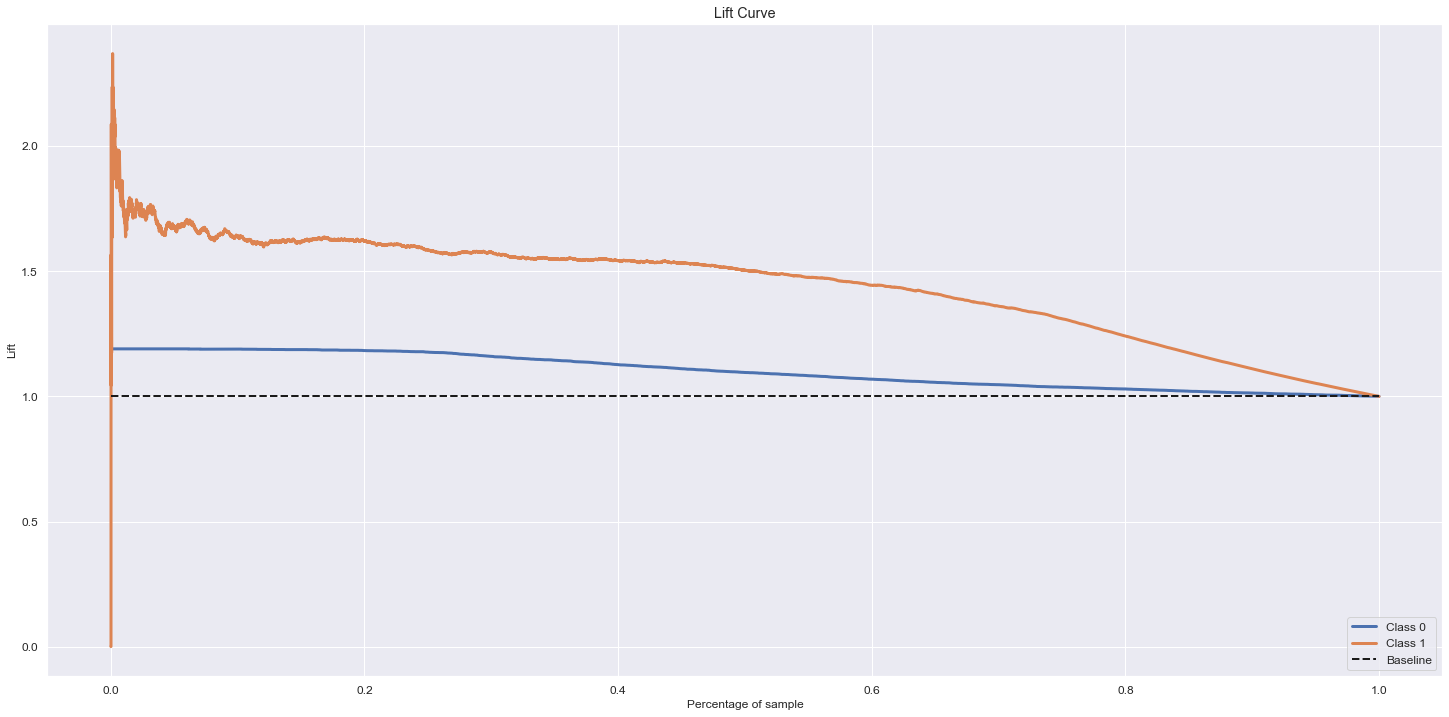

In [837]:
# Acumulative Gain
skplt.metrics.plot_lift_curve( y_val, yhat_et );

* Depois de pegar 5% da base de dados, ele se mantém com um lift de aproximadamente 1.70 mas quando chega a 60% base de dados começa a cair gradualmente o número de clientes interessados.

* Significa que para a classificação de clientes interessados, o modelo é 1.70 melhor do que fazer a seleção aleatória do dataset

## 7.4 Random Forest

In [838]:
# Model Definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
rf.fit(x_train, y_train)

# model predict
yhat_rf = et.predict_proba( x_val )


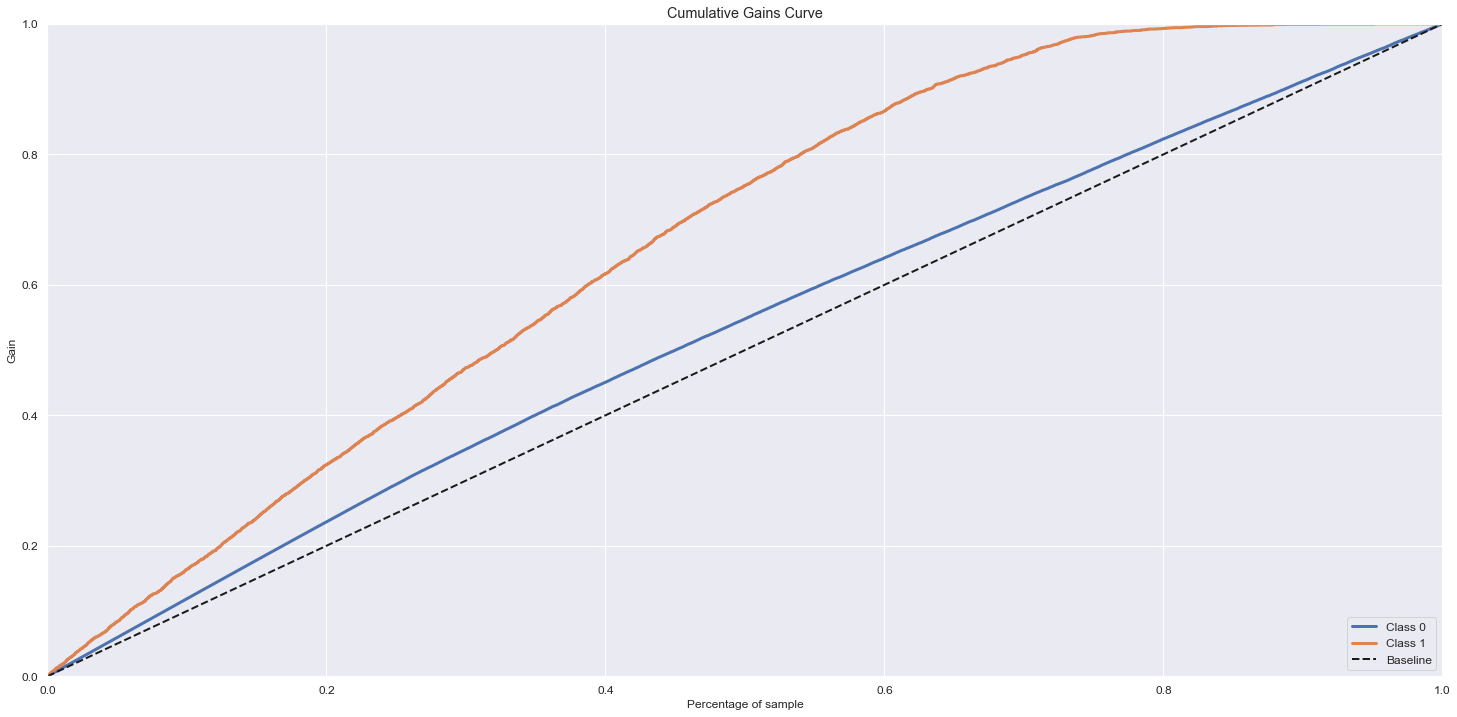

In [839]:
# Acumulative Gain -É UMA METRICA QUE MEDE A PERFORMANCE DO MODELO
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );


# *  Acumulative Gain -É uma metrica que avalia a eficiencia do modelo, em relacao a base de dados.  Quanto maior for o ganho, melhor será o modelo.
* Linha laranja = È a predicao do modelo 
* Linha Azul = são os dados de teste  
* Linha tracejada  = É a base de dados. 

Analises

* Significa se o dataset for classificado pela probabilidade, para contemplar 100% dos interessados,será preciso apenas aproximadamente 75% da base de dados.

* A empresa diminuiria custos ao descartar 25% não interessados.

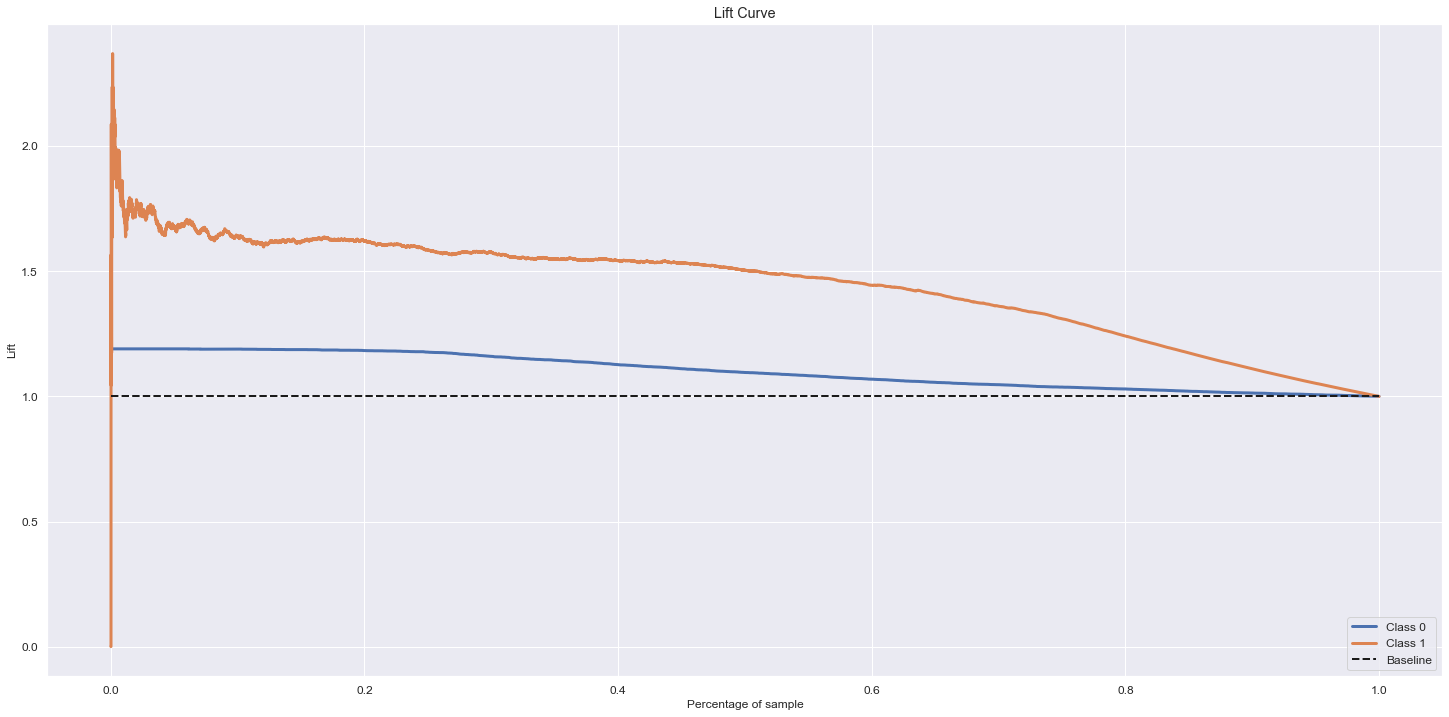

In [840]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

# *  Lyft Curve é a metrica o quanto o modelo é melhor que o aleatório.

* Depois de pegar 5% da base de dados, ele se mantém com um lift de aproximadamente 1.70 mas quando chega a 60% base de dados começa a cair gradualmente o número de clientes interessados.

* Significa que para a classificação de clientes interessados, o modelo é 1.70 melhor do que fazer a seleção aleatória do dataset.

# 8.0 Model Performance

* Metrica para medir a performance de ordenção;


### Precision and Recall
* Precision = de todos os clientes que o modelo predisse que estavam interessados, quantos realmente estavam interessados.

 O modelo esta acertando 120%
 
 
 
* Recall = De todos os clientes que realmente estao interessados, quantos o modelo predisse estar interessados. ( Class 1 )

 O modelo esta tem uma pontuacao de 99% de todas as predicoe.

In [891]:
# Ordenando pelos 20.000 clientes interessados

def precision_at_k( data, k=20000 ): 
    # Reset Index
    data = data.reset_index( drop=True )

    # Create rankings order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking'].sum()

    return data.loc[k, 'precision_at_k' ]


In [892]:
def recall_at_k( data, k=20000 ):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create rankings order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k' ]




In [898]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sorte Clients by propensity score
df8 = df8.sort_values( 'score', ascending=False)

# Compute Precision at k
precision_at_k20000 = precision_at_k( df8, k=20000 )
print( 'Precision at k: {}'.format( precision_at_k20000 ) )

Precision at k: 1.1920308416370946e-05


In [894]:
# Compute Recall at k
recall_at_k20000 = recall_at_k( df8, k=20000 )
print( 'Recall at k: {0:2f}%'.format( recall_at_k20000*100) )     

Recall at k: 98.528365%


* Precision - Significa que  o algoritimo tem uma probabilidade de acertar os clientes interessados de 100%
* Recall - Significa que o Algoritimo tem uma possibilidade de pegar todos os clientes interessados de 95%

### Model Accuracy

* Accuracy tells you how often the model's predictions are correct.

  Com um trashold de 0.60, o modelo esta acertando 83% das predicoes.

In [902]:

# Calculate accuracy
df8['label'] = df8['score'].apply( lambda x: 1 if x > 0.60 else 0)  
accuracy = accuracy_score(df8['response'], df8['label'])

print("Accuracy: {0:2f}%".format( accuracy * 100) )

Accuracy: 83.993937%


## 8.1 Manually curve cumulative

<AxesSubplot:xlabel='base_cum_perc', ylabel='real_cum_perc'>

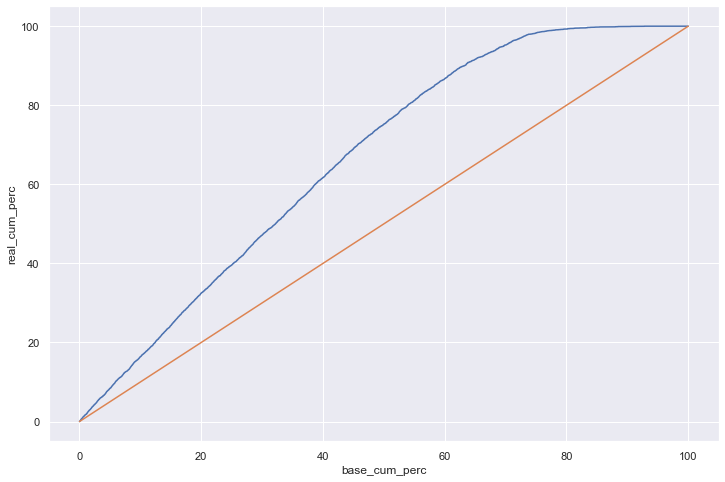

In [866]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# Ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset - Propensity Score
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base - Clients
results['base'] = range( 1, len( results ) + 1 ) 
results['base_cum_perc'] = 100*results['base']/len ( results )

# Baseline Model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12, 8) )
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )
sns.lineplot( x='base_cum_perc', y='baseline', data=results )

## 8.2 Manually Lift Curve

<AxesSubplot:xlabel='base_cum_perc', ylabel='lift'>

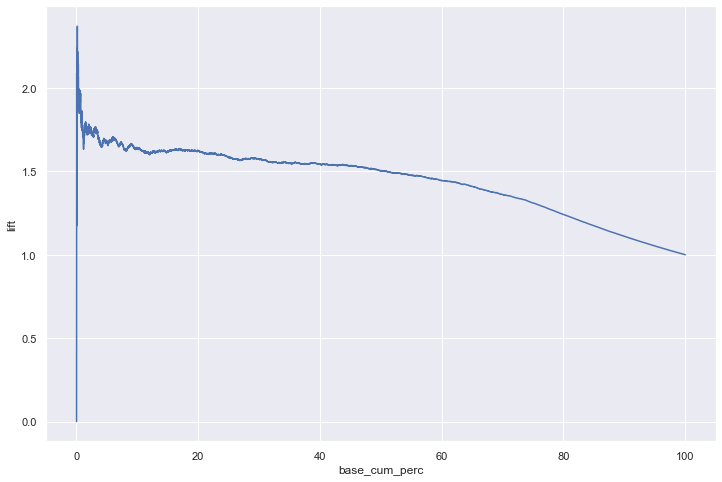

In [867]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# Ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset - Propensity Score
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base - Clients
results['base'] = range( 1, len( results ) + 1 ) 
results['base_cum_perc'] = 100*results['base']/len ( results )

# Baseline Model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12, 8) )
sns.lineplot( x='base_cum_perc', y='lift', data=results )

In [868]:
results.head()

,prediction,real,real_cum,real_cum_perc,base,base_cum_perc,baseline,lift
19931,0.879,0,0,0.000000,1,0.003789,0.003789,0.000000
2767,0.848,0,0,0.000000,2,0.007579,0.007579,0.000000
7067,0.822,0,0,0.000000,3,0.011368,0.011368,0.000000
2182,0.803,1,1,0.023736,4,0.015157,0.015157,1.565986
20289,0.761,0,1,0.023736,5,0.018947,0.018947,1.252789


# 10.0 Business Performance 



## 10.1 Manually ROI Curve

Roy curve, é um grafico de linha que mostra o comportamento de ganho do modelo.

In [869]:

# Compute Bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else
                                                             0.8 if ( x >= 0.80) & ( x <= 0.90) else
                                                             0.7 if ( x >= 0.70) & ( x <= 0.80) else
                                                             0.6 if ( x >= 0.60) & ( x <= 0.70) else
                                                             0.5 if ( x >= 0.50) & ( x <= 0.60) else
                                                             0.4 if ( x >= 0.40) & ( x <= 0.50) else
                                                             0.3 if ( x >= 0.30) & ( x <= 0.40) else
                                                             0.2 if ( x >= 0.20) & ( x <= 0.30) else
                                                             0.1 if ( x >= 0.10) & ( x <= 0.20) else 0.01 )


#Aggreging Clients among Buckets
df = results[['prediction', 'bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'propensity_score', 'clients']

# Compute Revenue and Cost
df['gross_revenue'] = 2300 * df['clients'] * df['propensity_score']
df['cost'] = 500 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# Revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )


<AxesSubplot:xlabel='base', ylabel='revenue'>

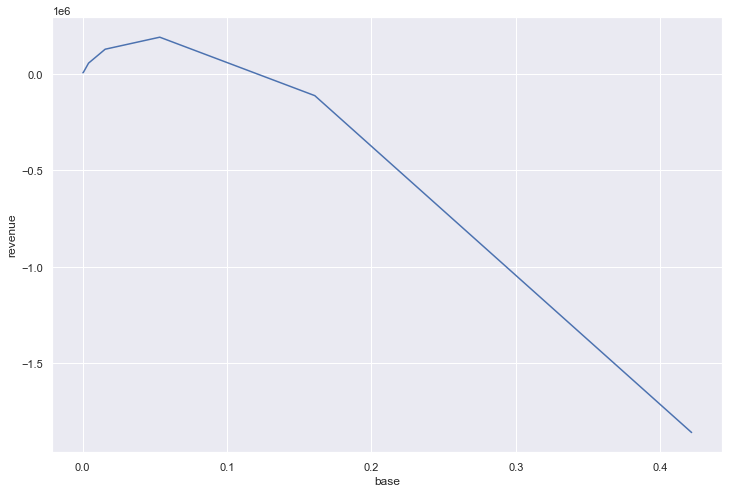

In [870]:
plt.figure( figsize=(12,8) )
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux)

# Model Result
Essa seria atabela que seria entregue aos managers  para auxiliar na tomada de decisao.

In [871]:
df10 = df.copy()
df10[ 'revenue' ] = df10[ 'revenue'].map( '${:,.2f}'.format)
df10[ 'gross_revenue' ] = df10[ 'gross_revenue'].map( '${:,.2f}'.format)
df10[ 'cost' ] = df10[ 'cost'].map( '${:,.2f}'.format)
df10

,index,propensity_score,clients,gross_revenue,cost,base,revenue
8,0.80,0.803,4,"$7,387.60","$2,000.00",0.000152,"$5,387.60"
7,0.70,0.708,5,"$8,142.00","$2,500.00",0.000341,"$5,642.00"
6,0.60,0.601,14,"$19,352.20","$7,000.00",0.000872,"$12,352.20"
5,0.50,0.500,85,"$97,750.00","$42,500.00",0.004092,"$55,250.00"
4,0.40,0.400,303,"$278,760.00","$151,500.00",0.015574,"$127,260.00"
3,0.30,0.300,998,"$688,620.00","$499,000.00",0.053391,"$189,620.00"
2,0.20,0.200,2833,"$1,303,180.00","$1,416,500.00",0.160743,"$-113,320.00"
1,0.10,0.100,6886,"$1,583,780.00","$3,443,000.00",0.421675,"$-1,859,220.00"
0,0.01,0.000,15262,$0.00,"$7,631,000.00",1.000000,"$-7,631,000.00"


## * considerando trabalhar apenas com clientes que tem uma probabilidade acima de 30% de chances de comprar o produto, com um custo de clientes de  500,00 e a venda de cada apolice no valor de  2,300.00 para cada cliente interessado.

# 11.0 Questions 

In [851]:
print( 'Total Number of customer to work with: {:,.2f}'.format( ( df.iloc[ 0:6, 2].sum() ) ) ) 
print( 'Total Cost of customer to work with: ${:,.2f}'.format( ( df.iloc[ 0:6, 4].sum() ) ) ) 
print( 'Total Gross Revenue of customer to work with: ${:,.2f}'.format( ( df.iloc[ 0:6, 3].sum() ) ) ) 
print( 'Total Expected Revenue from customers to work with: ${:,.2f}'.format( ( df.iloc[ 0:6, 6].sum() ) ) ) 

Total Number of customer to work with: 1,409.00
Total Cost of customer to work with: $704,500.00
Total Gross Revenue of customer to work with: $1,100,011.80
Total Expected Revenue from customers to work with: $395,511.80


## 1. What are the main insights into the most relevant attributes of customers interested in purchasing auto insurance?

- Apenas 1% da base de dados estao interessados na compra de um novo serviço de carro.
- A receita esperada é de $395,511.80 dolares.
- Customers between 30-50 are more interested in a Vehicle Insurance;
- Custumer withy newest cars are more interested in a Vehicle Insurance;


## 2. What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?


Sim, o time de vendas tera capacidade de contactar todos os clientes interessados, ultilizando apenas 1409 ligacoes, o que representa 1% da base de dados

In [852]:
df12 = len( df_raw )
totalleads = df.iloc[ 0:6, 2].sum()
percust = totalleads/df12
print( 'Insurance All total leads: {}'.format(totalleads) )
print( 'Insurance All % of Calls: {0:2f}%'.format(percust*100) )

Insurance All total leads: 1409
Insurance All % of Calls: 1.067845%


## 3. If the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?



Infelizmente, nao sera necessario o aumento de ligacoes porque devido ao baixo numero de interessados, a capacidade do time vendas é mais que suficiente para atender todos os clientes interessados.

In [853]:
calls = 40000
totalleads = df_test.shape[1]
percalls = calls/totalleads
print( 'Insurance All total leads: {}'.format(totalleads) )
print( 'Insurance All % of Calls: {0:2f}%'.format(percalls*100) )

#a = df4.loc[df4['response'] == 1, 'gender']

Insurance All total leads: 12
Insurance All % of Calls: 333333.333333%


# 11.0 Next Step

* To enhance the Model Result:

    -  Verificar quais sao as variaveis externas que aumentam a probabilidade do cliente querer um seguro de carro.
    - Coletar mais dados em relacao ao cliente como, salarios, onde mora, numero de filhos, tem casa propria ou nao, para ajudar o modelo selecionar os clientes interessados com mais precisao.
    - Verificar o que pode abaixar os custos do clientes.
    - Categorizar quais tipos de serviços de seguros seriam ofercidos. ( apolice completa ou apenas para terceiros )
   
    
    